# Note: This notebook takes from the webinar on stardist [link text](https://www.youtube.com/watch?v=Amn_eHRGX5M)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install stardist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 10.3 MB/s eta 0:00:00


In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

from skimage import io
import os


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input

np.random.seed(42)
lbl_cmap = random_label_cmap()

Import the data from DataCollection folder

---



1. Using a folder that includes the images and label masks for the training and test cases. The folder has the following structure:

```
data
 |-mydata
 | |-train
 | | |-images
 | | | | image1.tif
 | | | | image2.tif
 | | | | ...
 | | |-masks
 | | | | mask1.tif
 | | | | mask2.tif
 | | | | ...
 | |-test
 | | |-images
 | | | | ...
 | | |-masks
 | | | | ...
 ```


```

In [ ]:
# Get the sorted list of file paths
image_paths = sorted(glob('/content/drive/MyDrive/Grain Boundary Detection/Stardist/data/mydata/train/images/*.tif'))
mask_paths = sorted(glob('/content/drive/MyDrive/Grain Boundary Detection/Stardist/data/mydata/train/masks/*.tif'))

# Read the images and masks into arrays
X = [io.imread(image_path) for image_path in image_paths]
Y = [io.imread(mask_path) for mask_path in mask_paths]
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize images and fill small label holes.




In [ ]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 91/91 [00:00<00:00, 124.98it/s]


Split into train and validation datasets.

In [ ]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = np.array([X[i] for i in ind_val]), np.array([Y[i] for i in ind_val])
X_trn, Y_trn = np.array([X[i] for i in ind_train]), np.array([Y[i] for i in ind_train])
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  91
- training:        77
- validation:      14


In [ ]:
print(X[0].shape)
print(Y[0].shape)

(256, 256)

Training data consists of pairs of input image and label instances.

In [ ]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

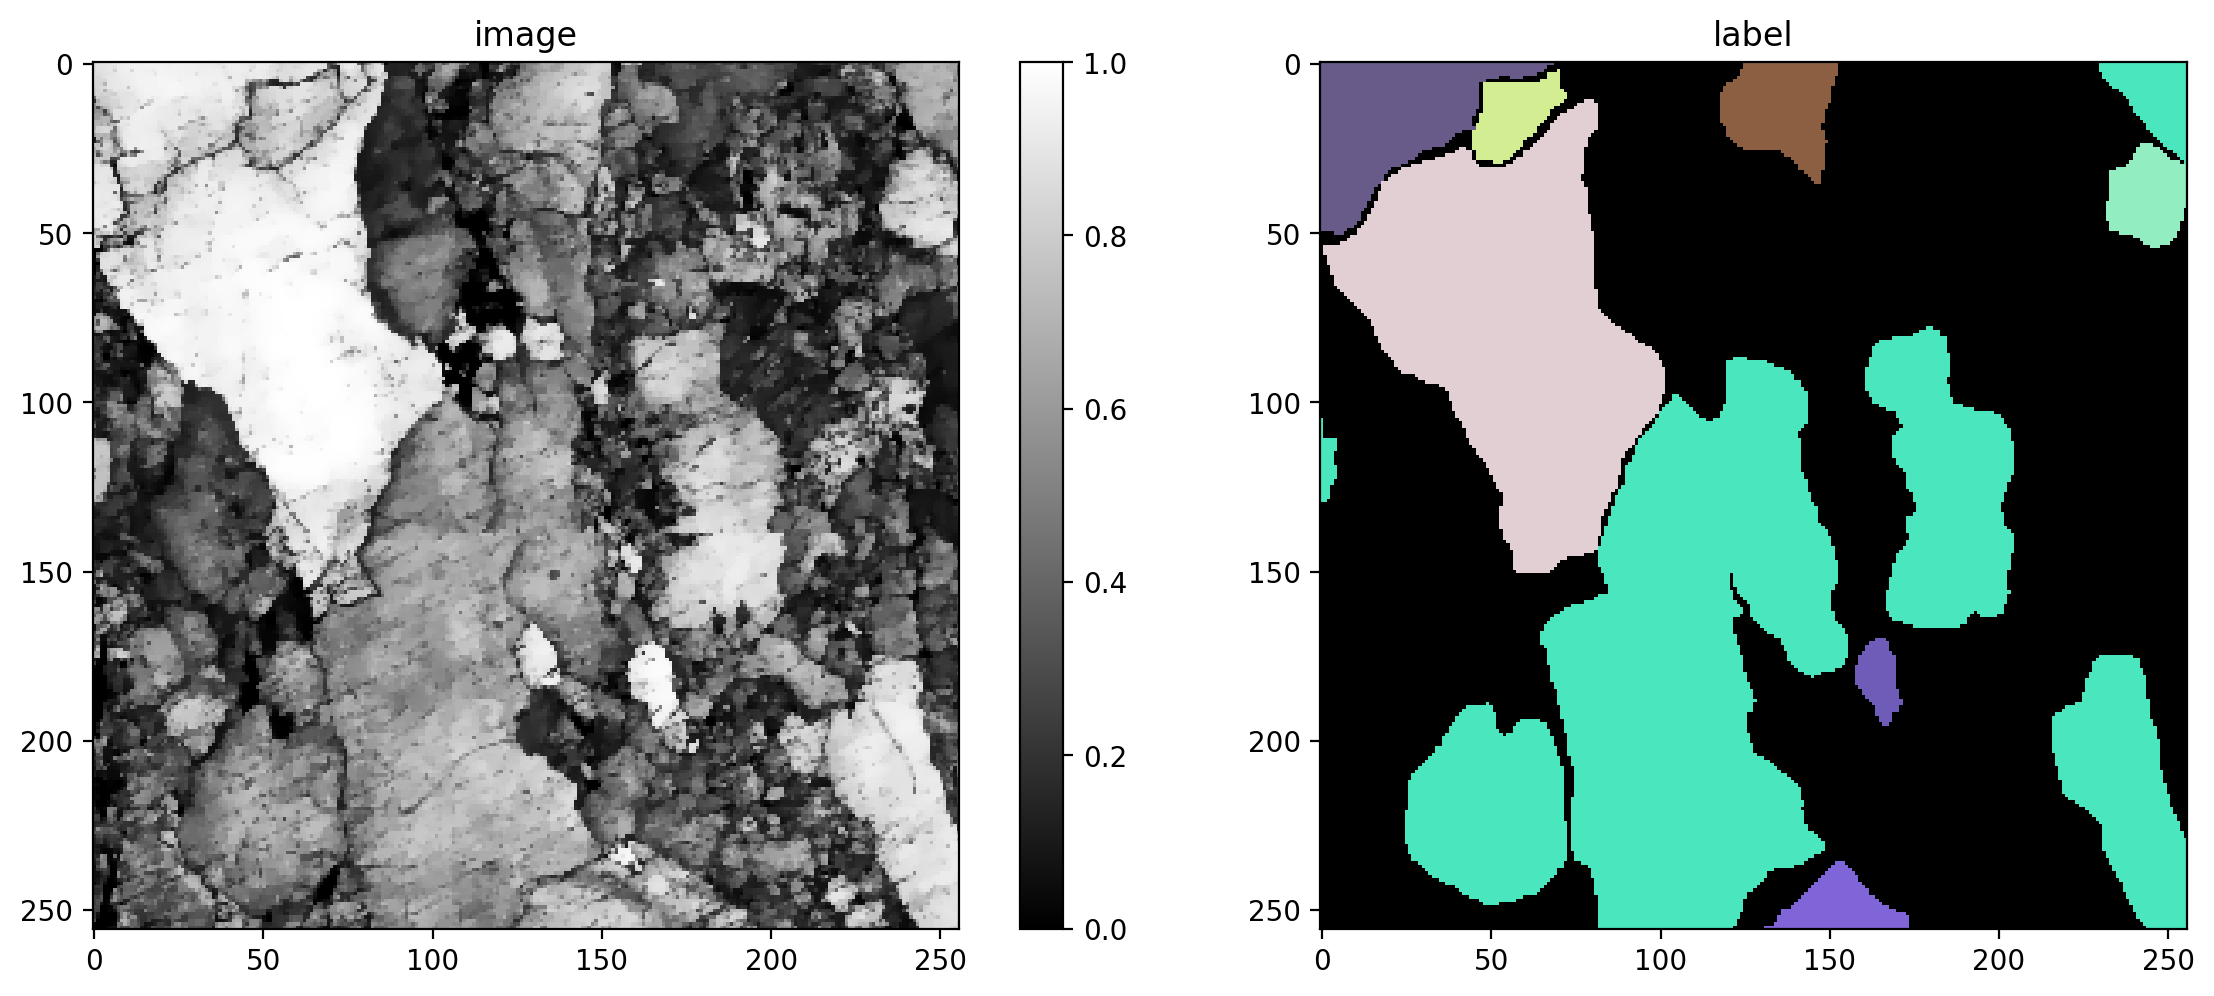

In [ ]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [ ]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [ ]:
# 256 Trying agian with lots of rays
n_rays = 126

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (1,1)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_shape_completion  = False,
    train_learning_rate = 0.003,
    train_background_reg = 0.00001,
    train_patch_size = (126, 126),
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=127, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=126, grid=(1, 1), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(126, 126), train_background_reg=1e-05, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 127,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 126,
 'grid': (1, 1),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (126, 126),
 'train_background_reg': 1e-05,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.003,


In [ ]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

# Data Augmentation

Define a function/callable that applies augmentation to each batch of the data generator.  
Use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) images (can disable augmentation by setting `augmenter = None`).

In [ ]:
def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.2,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    # x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

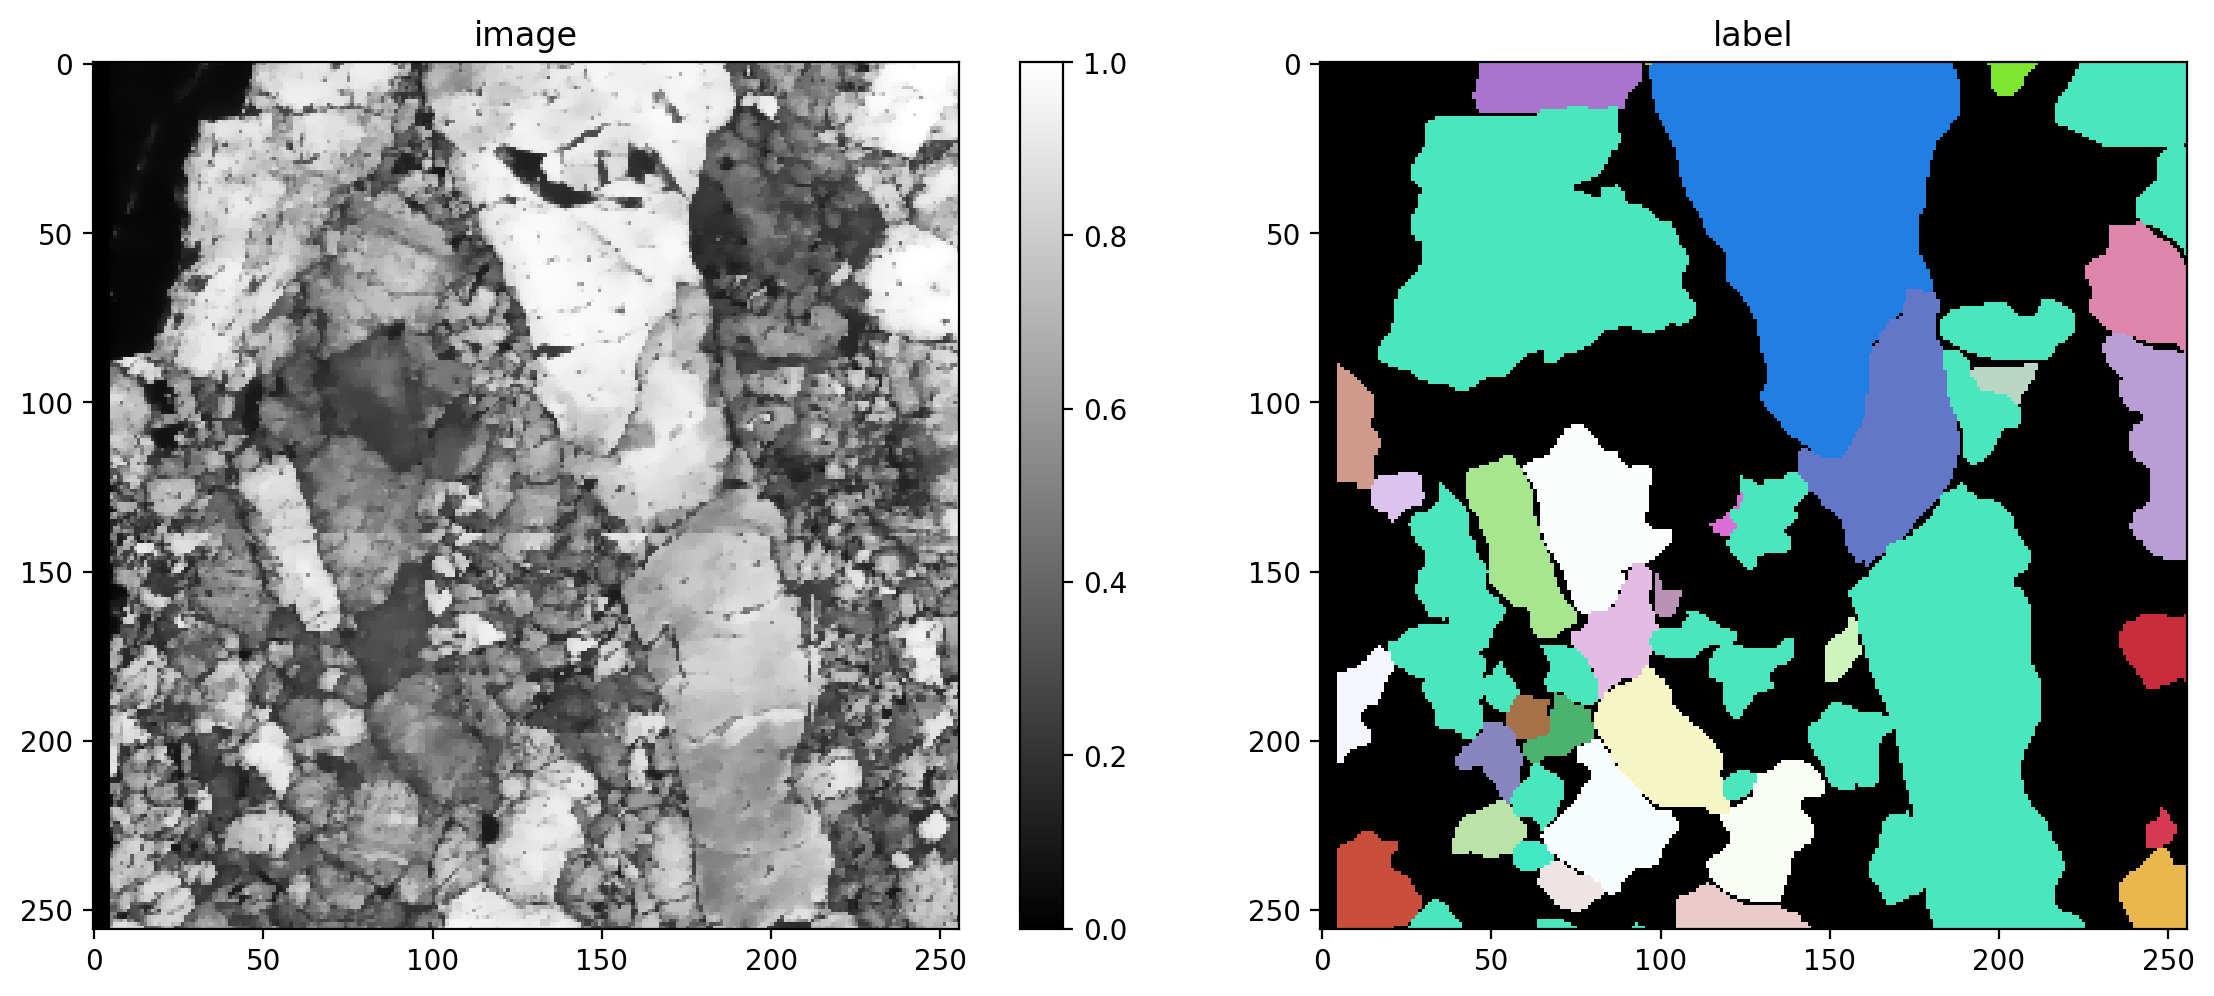

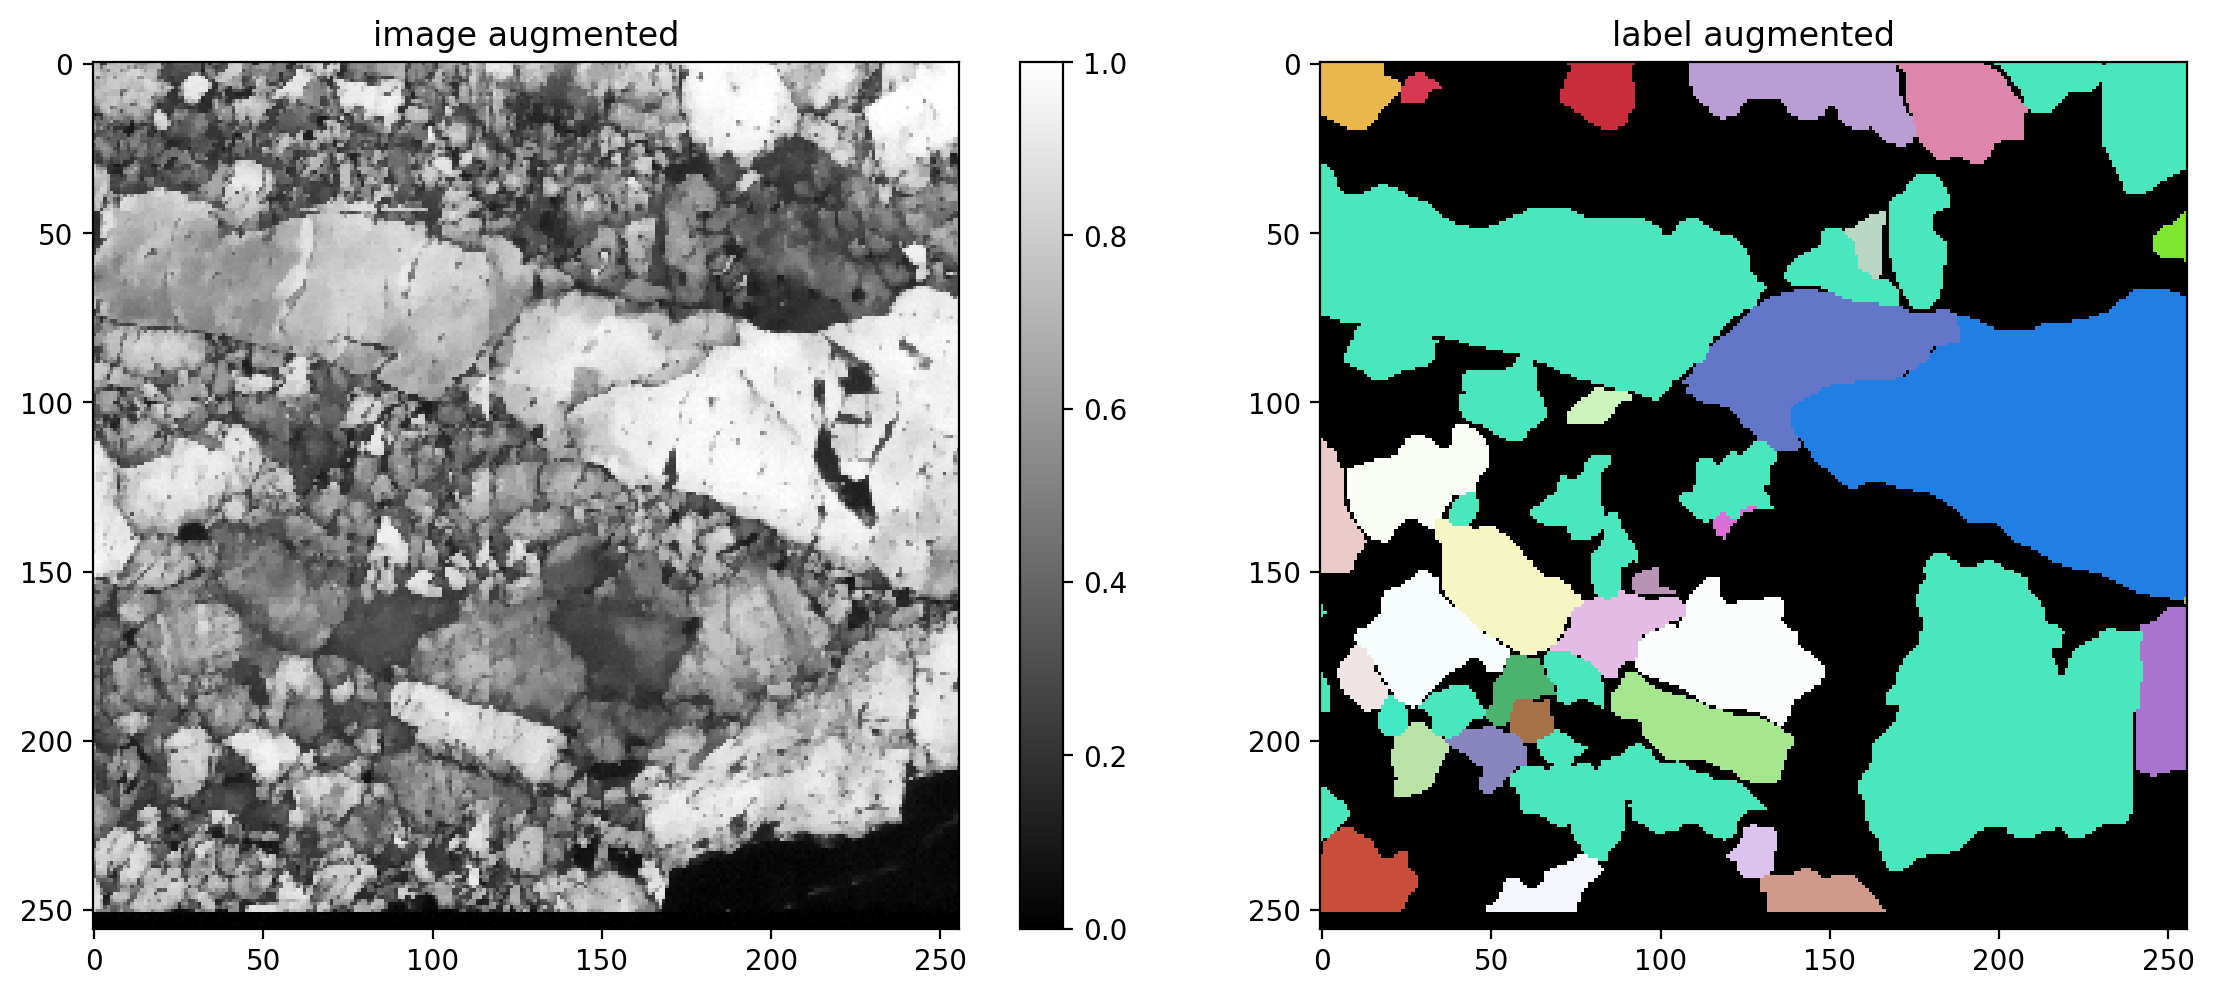

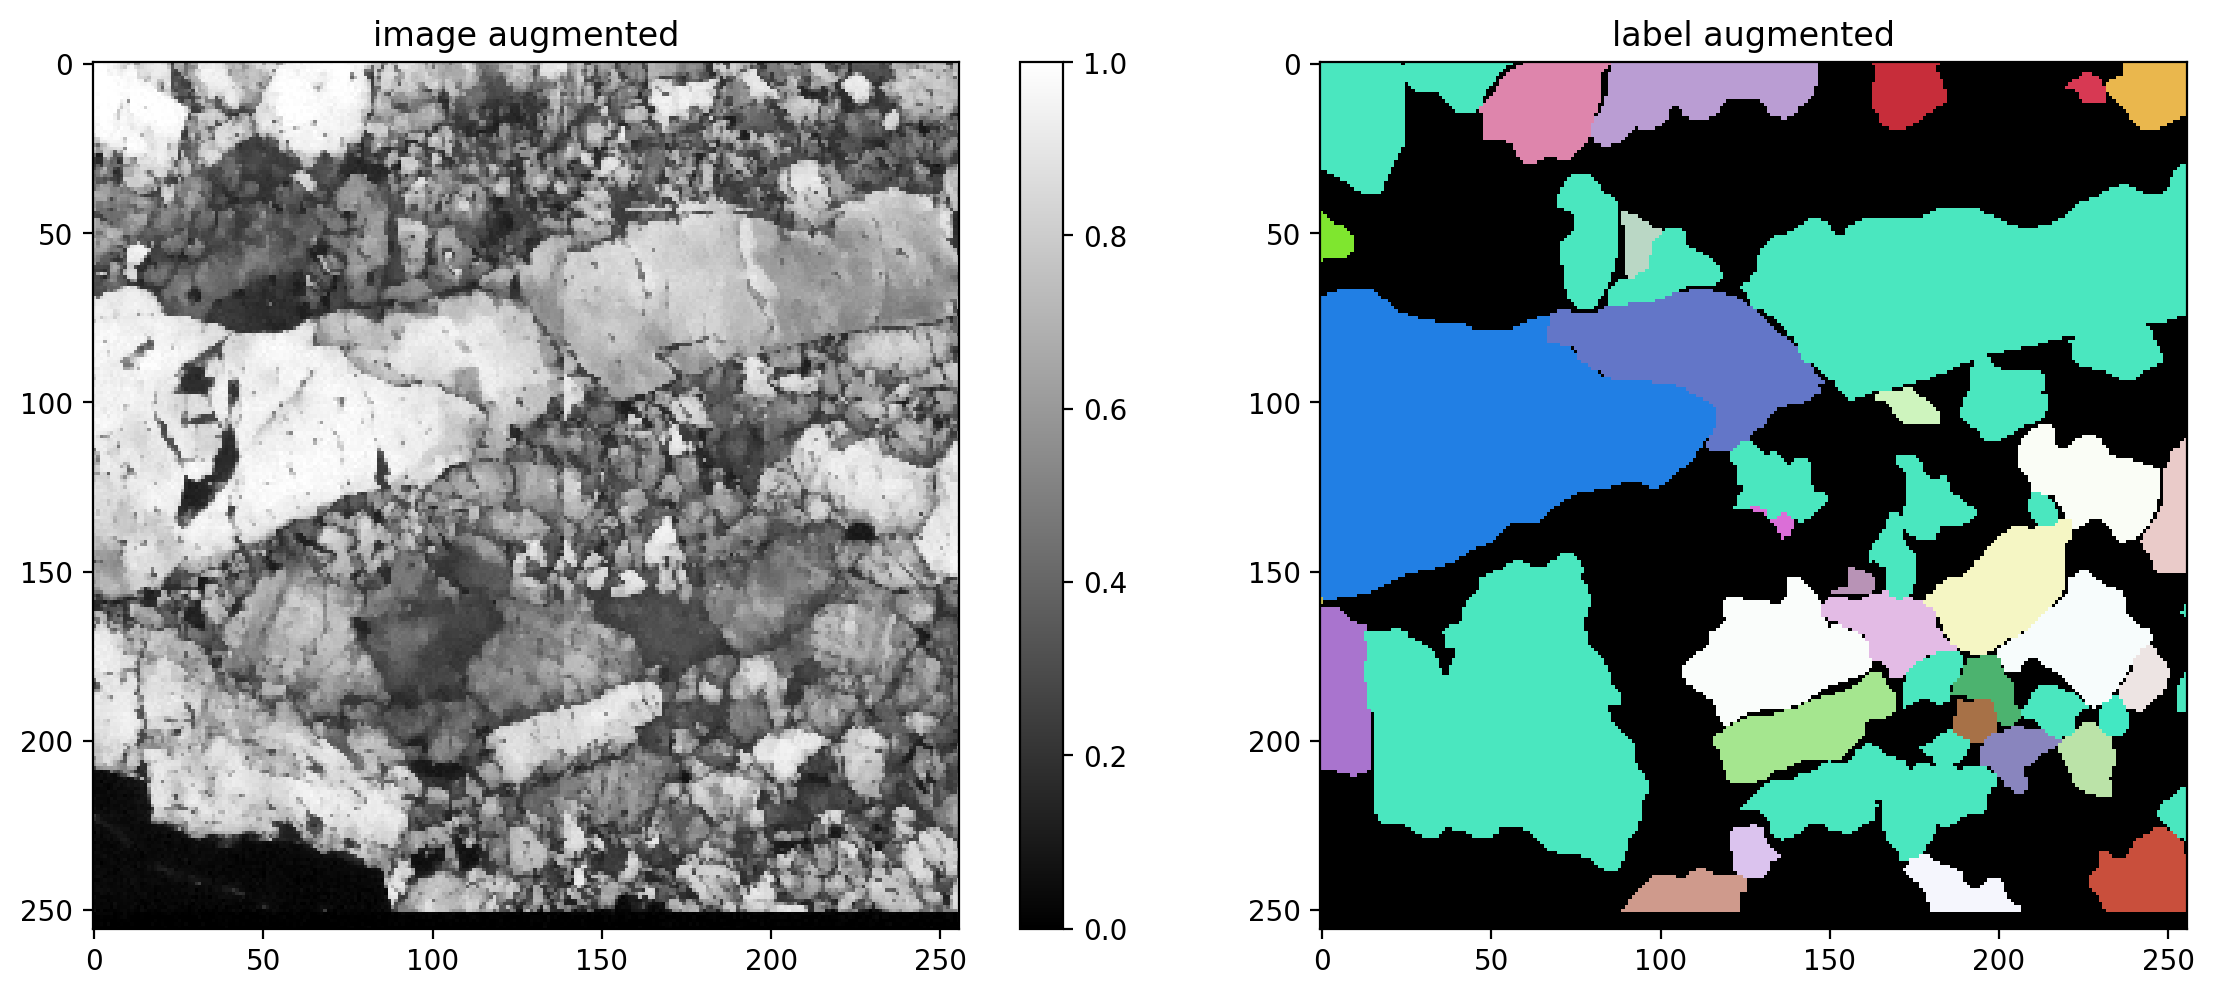

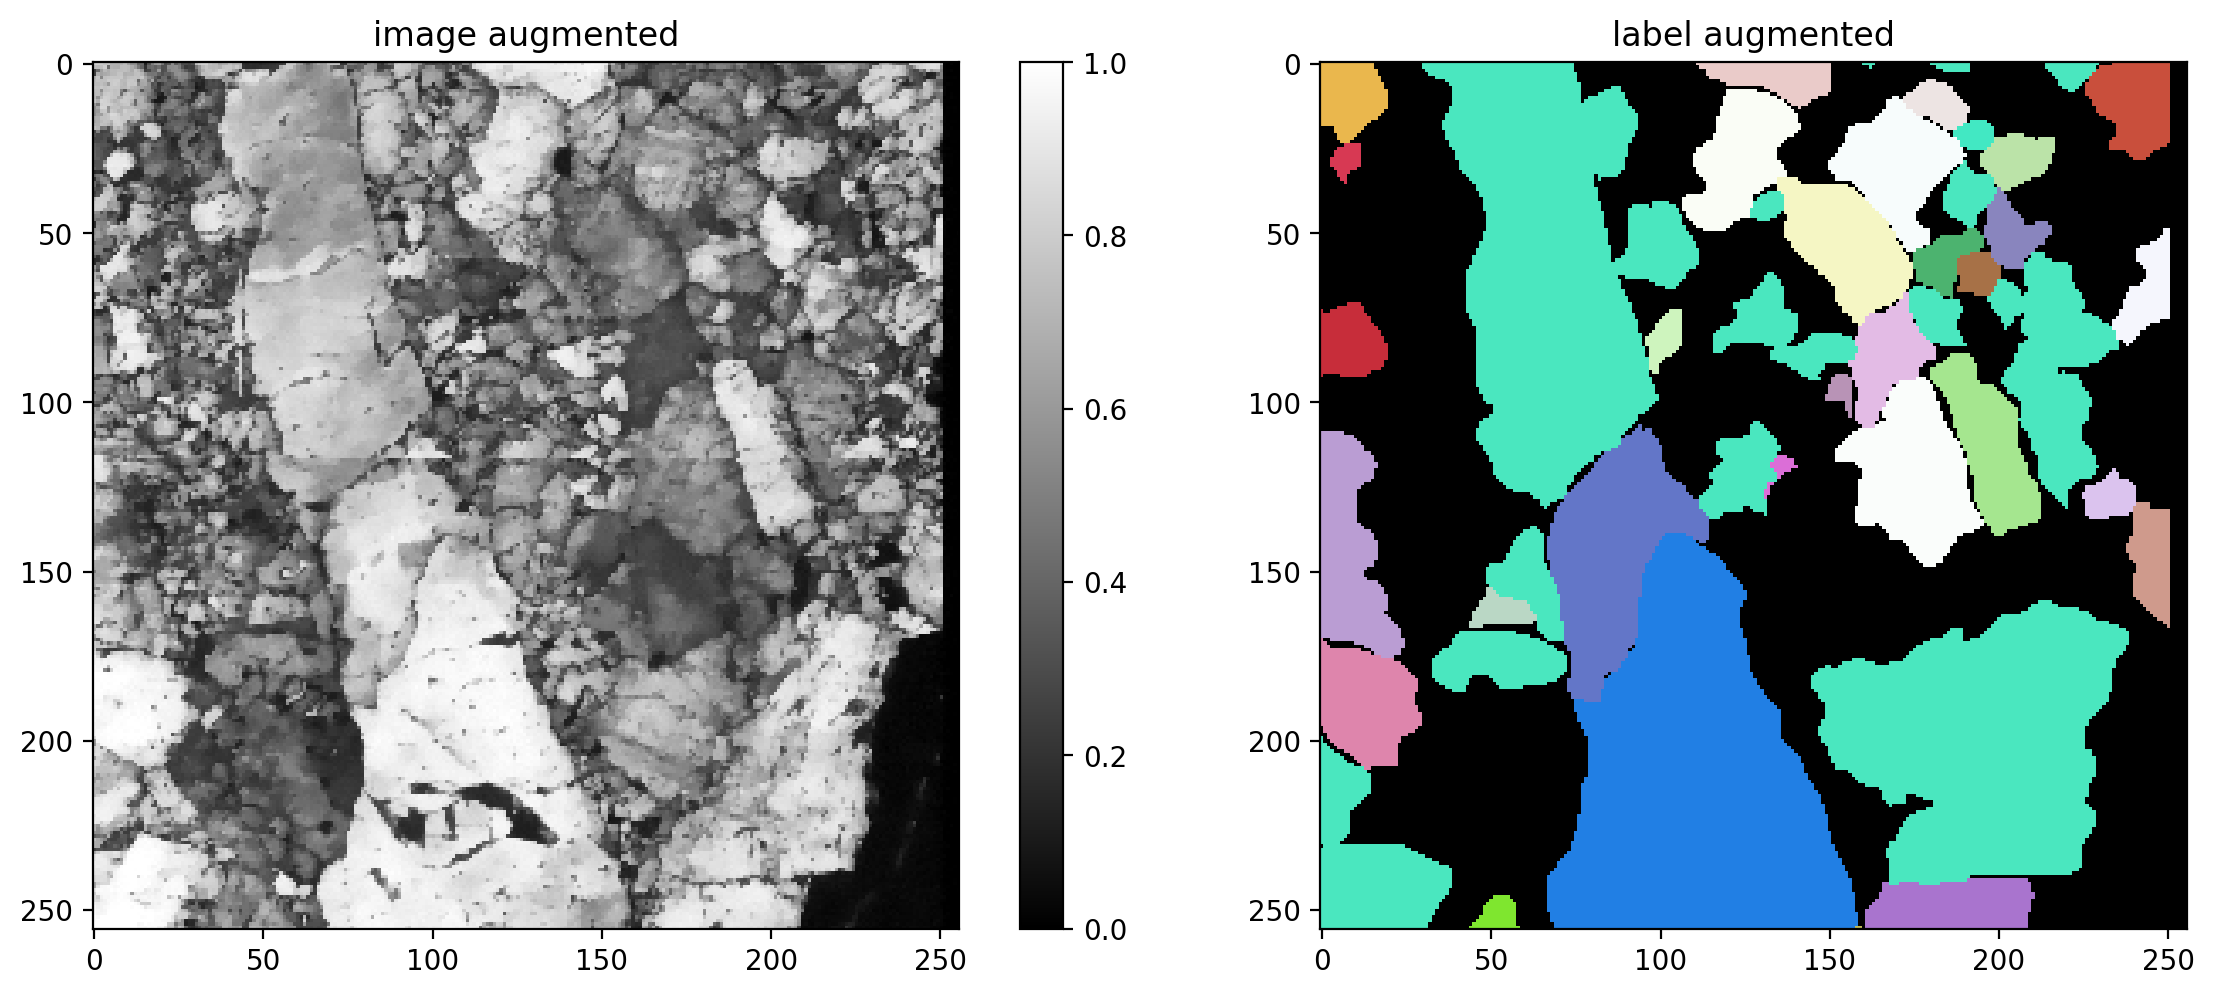

In [ ]:
# plot some augmented examples
img, lbl = X[5],Y[5]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

# Model API
---
- Currently using the pretrained 2D_versatile_fluo model
- Freezing all layers except last 3 from training on new images


**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [ ]:
# Loading pretrained model to display
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
5320433/5320433 [==============================] - 0s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


**Check if the neural network has a large enough field of view to see up to the boundary of most objects.**

---

In [ ]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [57. 43.]
network field of view :  [94 94]


In [ ]:
# Access the underlying Keras model
new_model = model.keras_model

# Freeze all layers except the last 3
for layer in new_model.layers[:-3]:
    layer.trainable = False

# Display model summary
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       320       ['input[0][0]']               
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 32)       9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, None, None, 32)       0         ['conv2d_1[0][0]']            
 D)                                                                                           

# Training

# Load pre-trained model (if applicable)

In [ ]:
# Path where the model is saved
# model_path = '/content/drive/MyDrive/Grain Boundary Detection/Stardist'

# Load the saved model
# loaded_model = tf.keras.models.load_model(model_path)

In [ ]:
# model = StarDist2D(None, name='trainedModel_126', basedir=model_path)

In [ ]:
# quick_demo = False

# if quick_demo:
#     print (
#         "NOTE: This is only for a quick demonstration!\n"
#         "      Please set the variable 'quick_demo = False' for proper (long) training.",
#         file=sys.stderr, flush=True
#     )
#     model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
#                 epochs=2, steps_per_epoch=10)

#     print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
#     model = StarDist2D.from_pretrained('2D_demo')
# else:
#     model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=100, steps_per_epoch=10)
# None;

Recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


# Train Functional API model
---
- Default Params on model:
  - epochs: 400
  - steps per epoch: 100
  -


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Create Tensorflow checkpoint object

# we will store the model in the following subdirectory within the current working directory.
checkpoint_path = '/content/drive/MyDrive/Grain Boundary Detection/Stardist/model_126'
checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             save_weights_only=False,
                             save_freq='epoch',
                             verbose=1)

In [ ]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=400, steps_per_epoch=100)

Epoch 1/400


Cause: Unable to locate the source code of <function _gcd_import at 0x787314d8b400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x787314d8b400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 26s 199ms/step - loss: 3.1235 - prob_loss: 0.3174 - dist_loss: 14.0303 - prob_kld: 0.1356 - dist_relevant_mae: 14.0291 - dist_relevant_mse: 787.4587 - dist_dist_iou_metric: 0.4947 - val_loss: 2.2048 - val_prob_loss: 0.2334 - val_dist_loss: 9.8572 - val_prob_kld: 0.1010 - val_dist_relevant_mae: 9.8558 - val_dist_relevant_mse: 340.5024 - val_dist_dist_iou_metric: 0.5318 - lr: 3.0000e-04
Epoch 2/400
100/100 [============================

# Threshold optimization

In [ ]:
quick_demo = False

if quick_demo:
    model.optimize_thresholds(X_val[:2], Y_val[:2])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:01<00:00,  9.50it/s, 0.456 -> 0.174]


Using optimized values: prob_thresh=0.454602, nms_thresh=0.3.


# Saving the model to be used later

In [ ]:
# Save StarDist model object in this path
model_path = '/content/drive/MyDrive/Grain Boundary Detection/Stardist/trainedModel_126.keras'

# Save the entire model in the native Keras format
model.keras_model.save(model_path)

# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function).
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [ ]:
# help(matching)

In [ ]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 14/14 [00:01<00:00,  8.00it/s]


IndexError: ignored

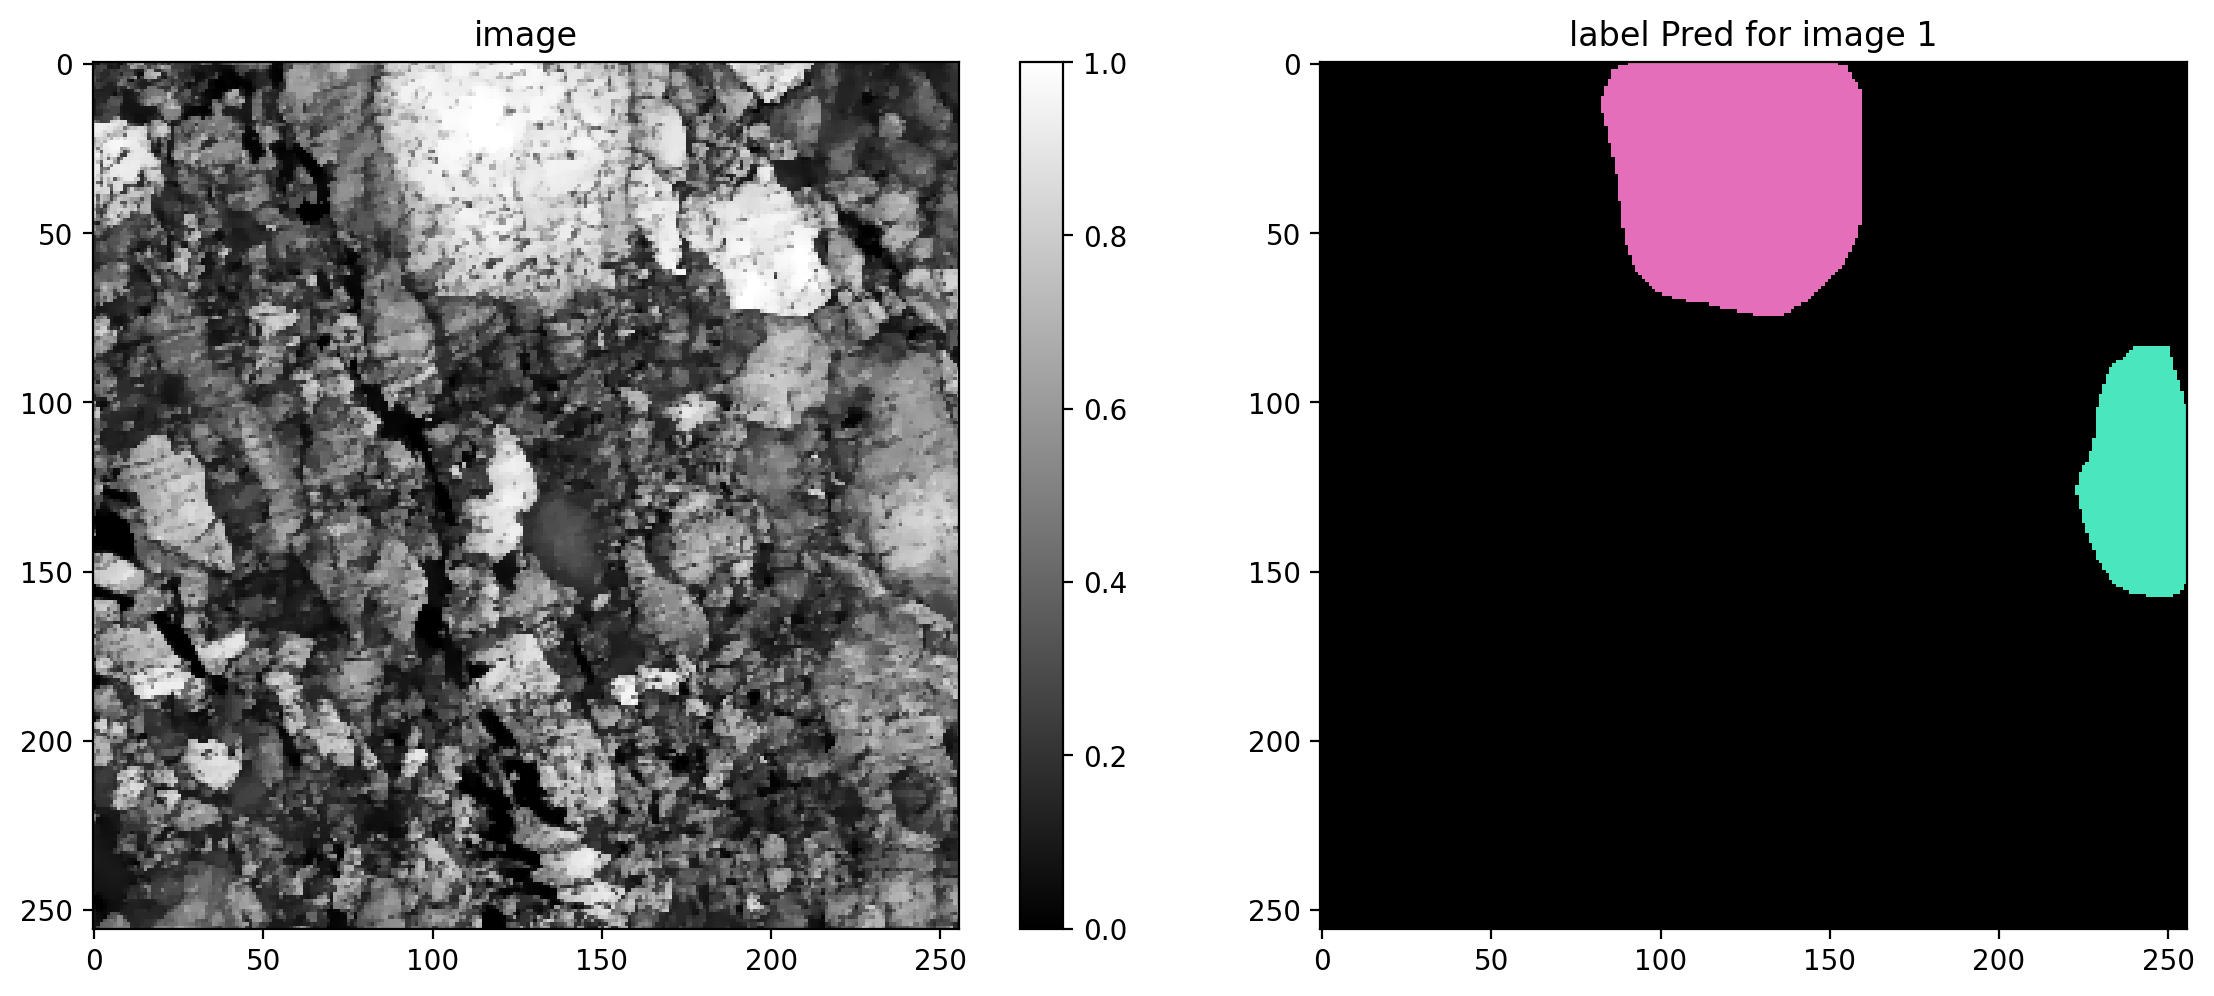

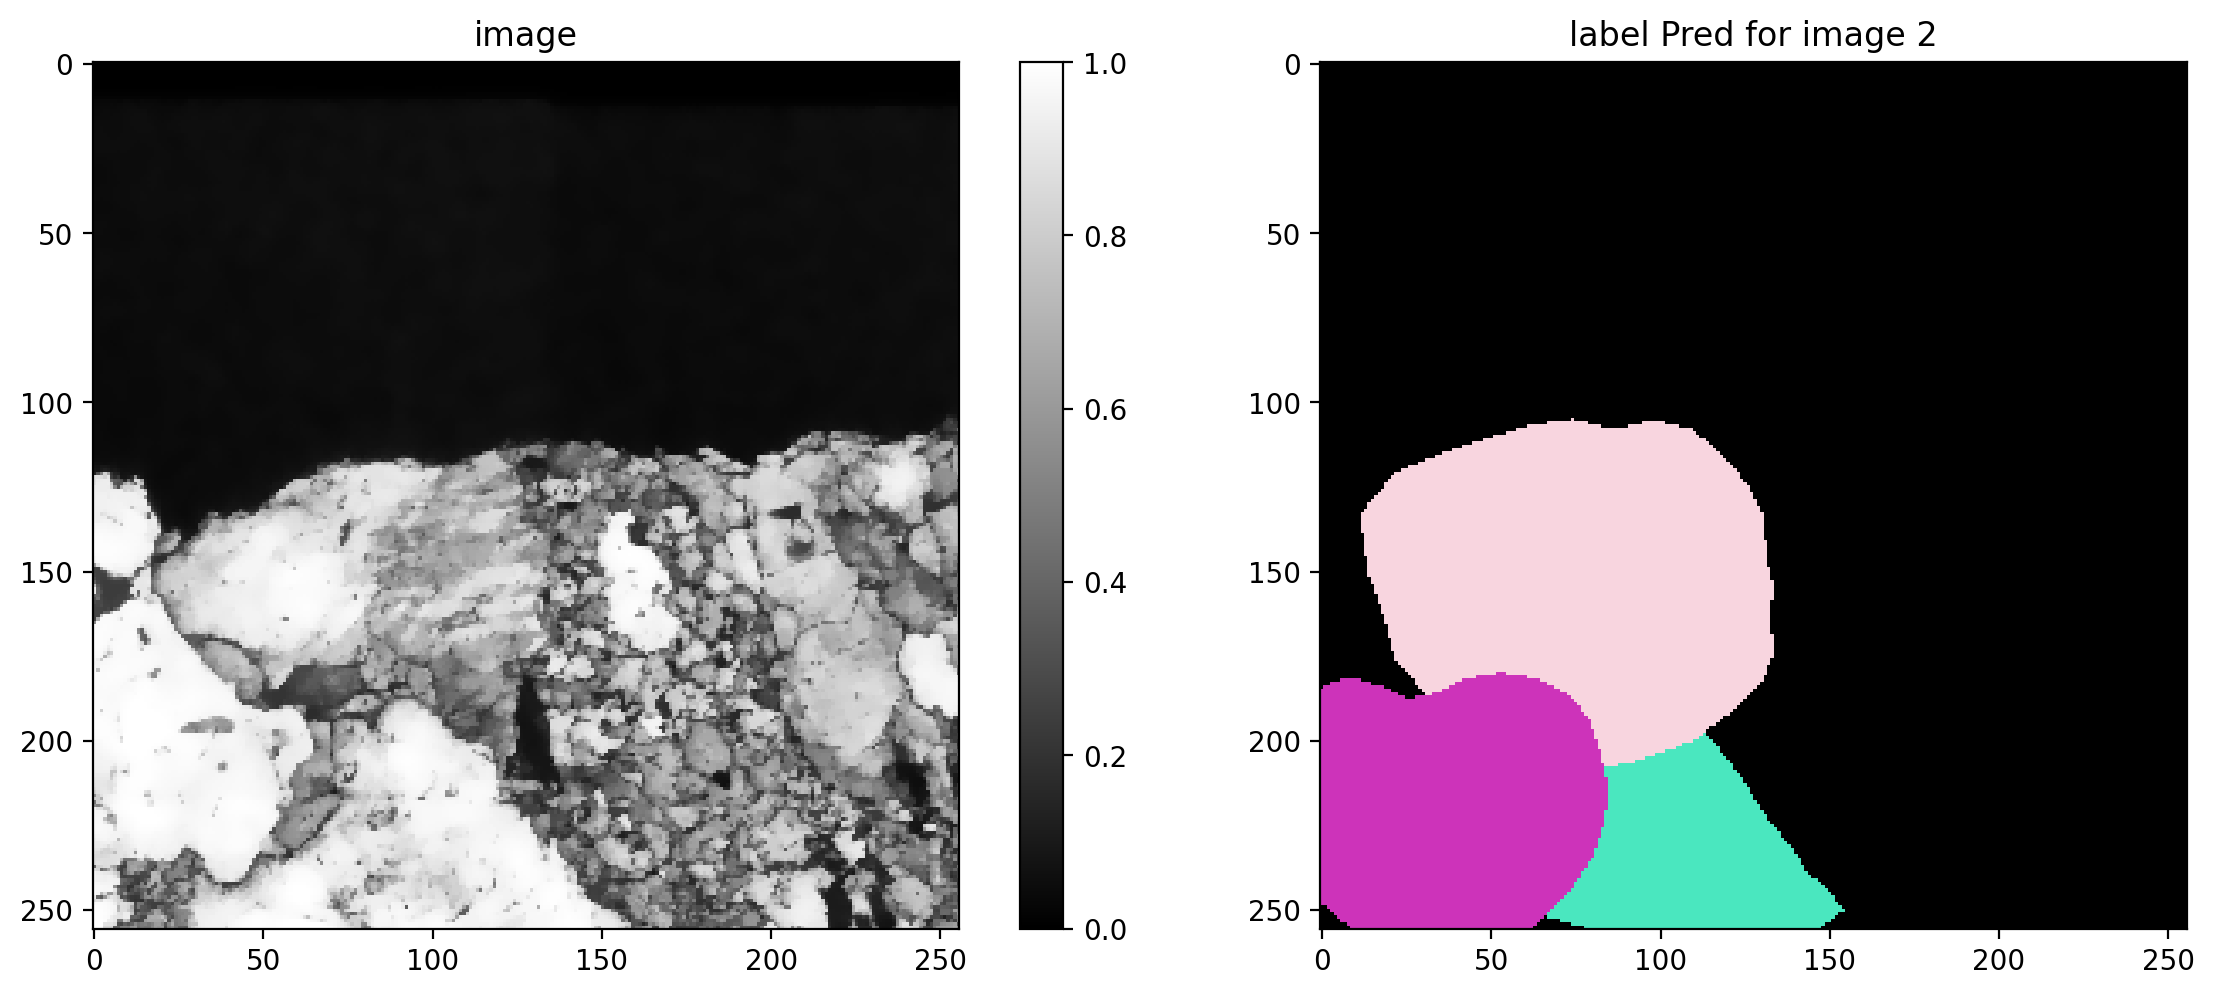

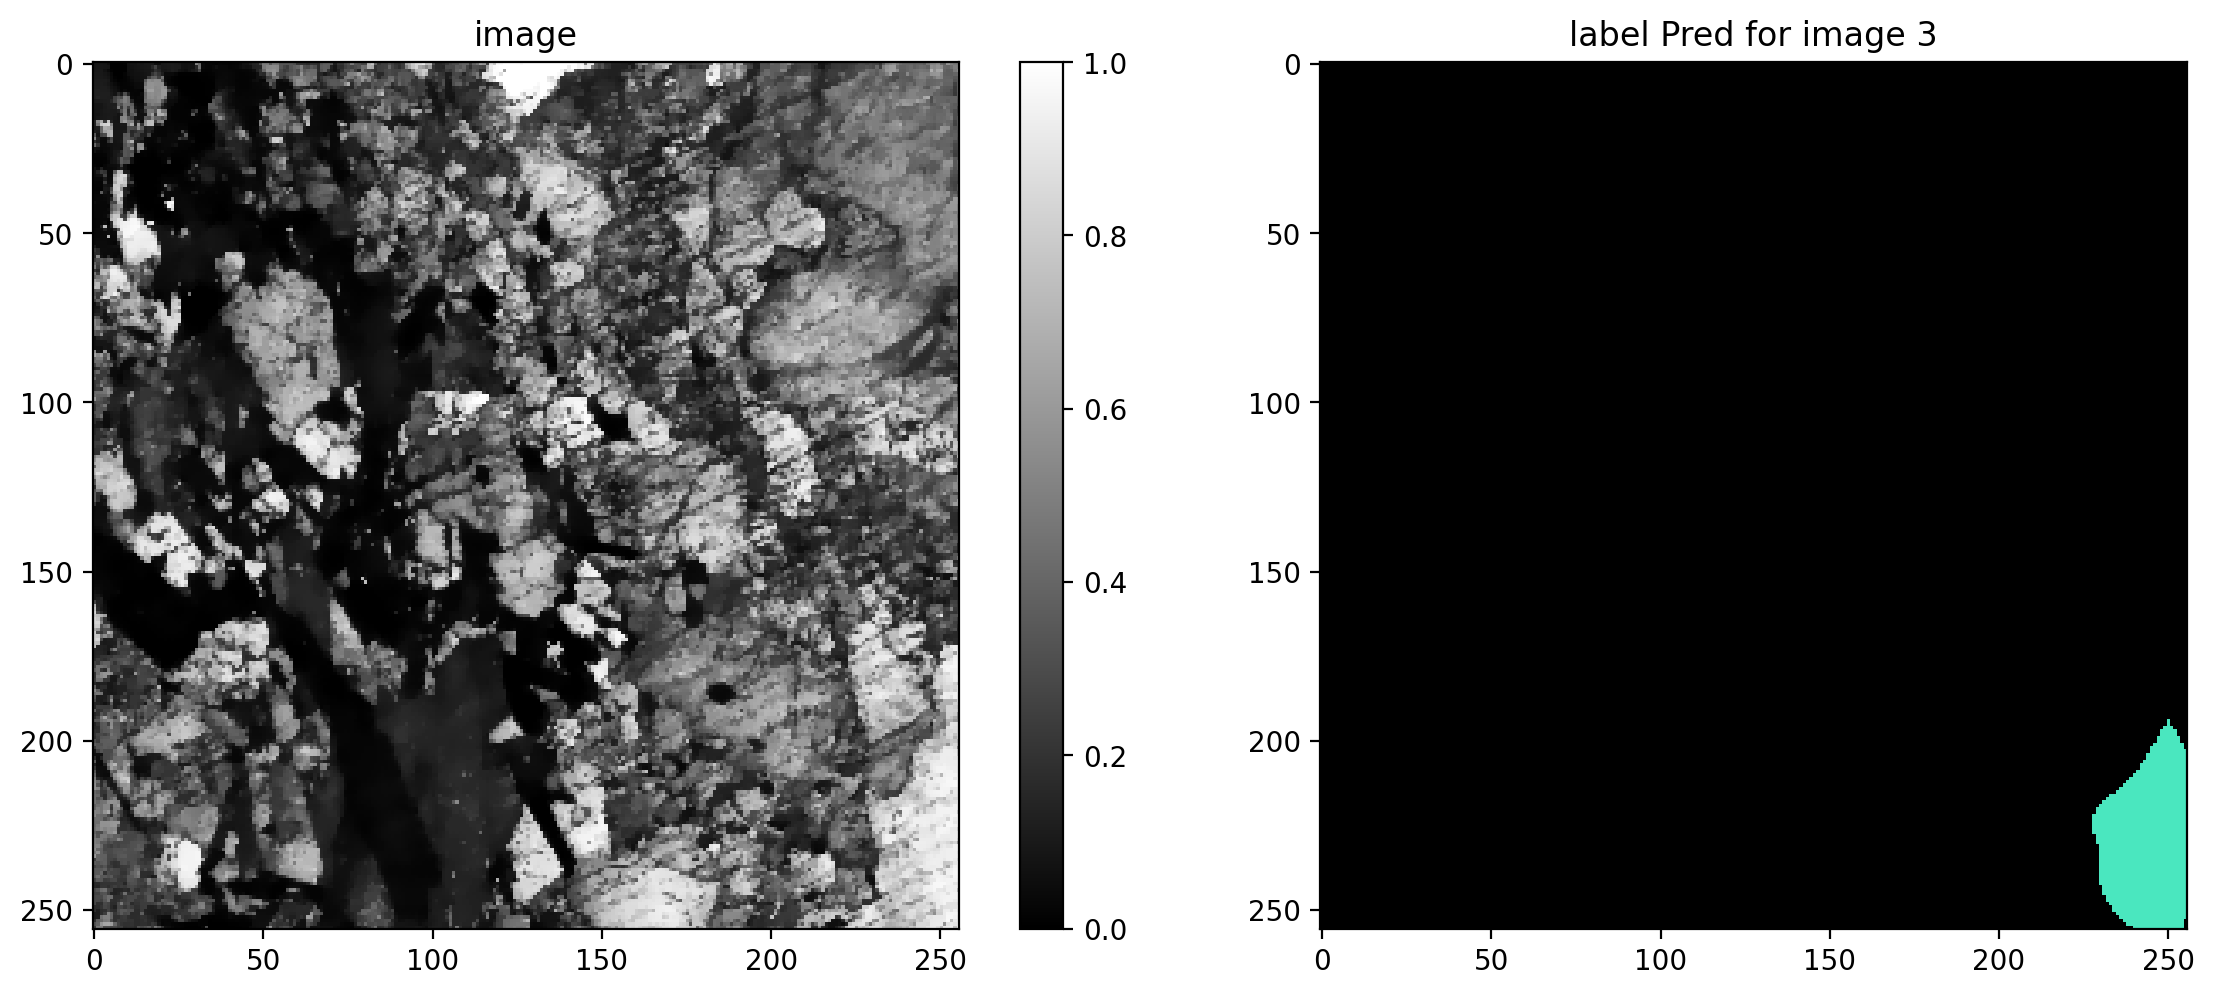

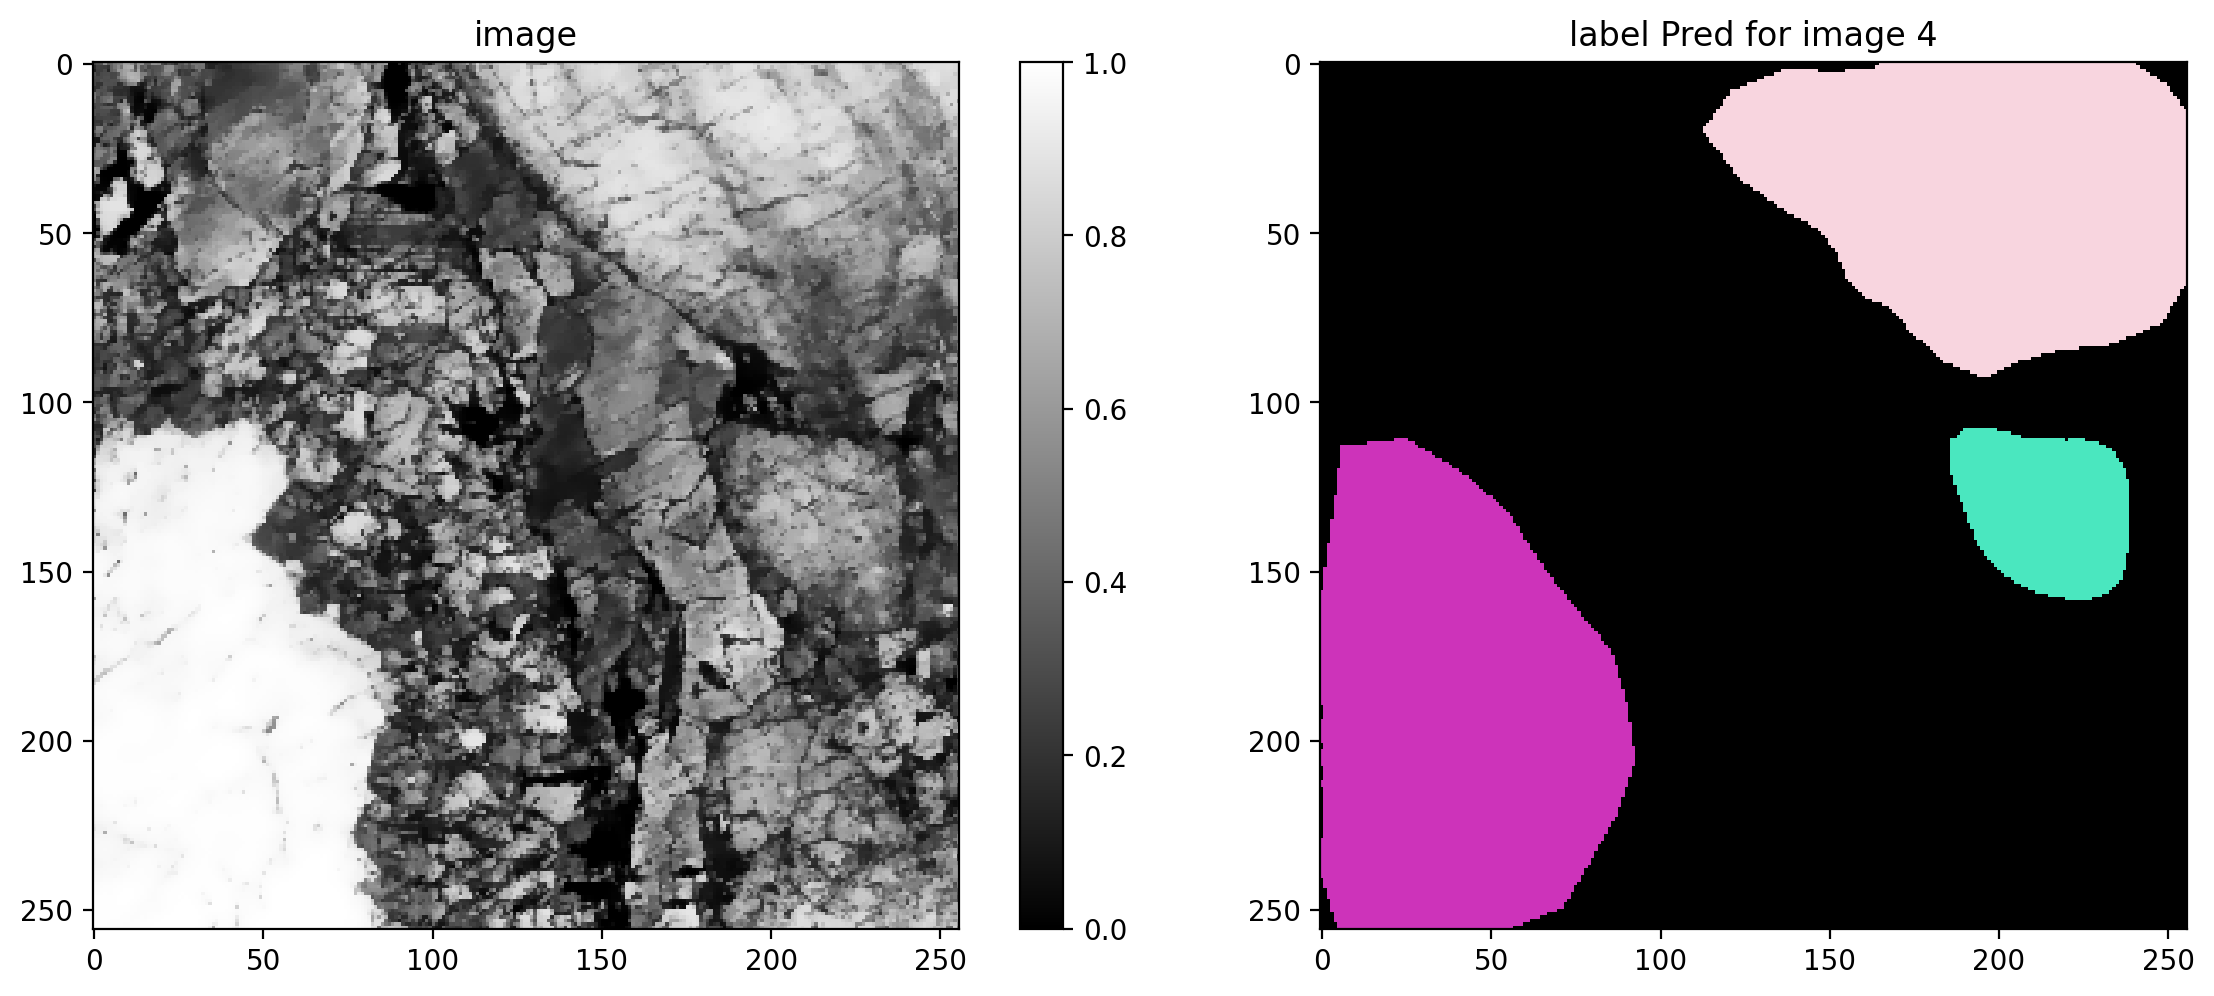

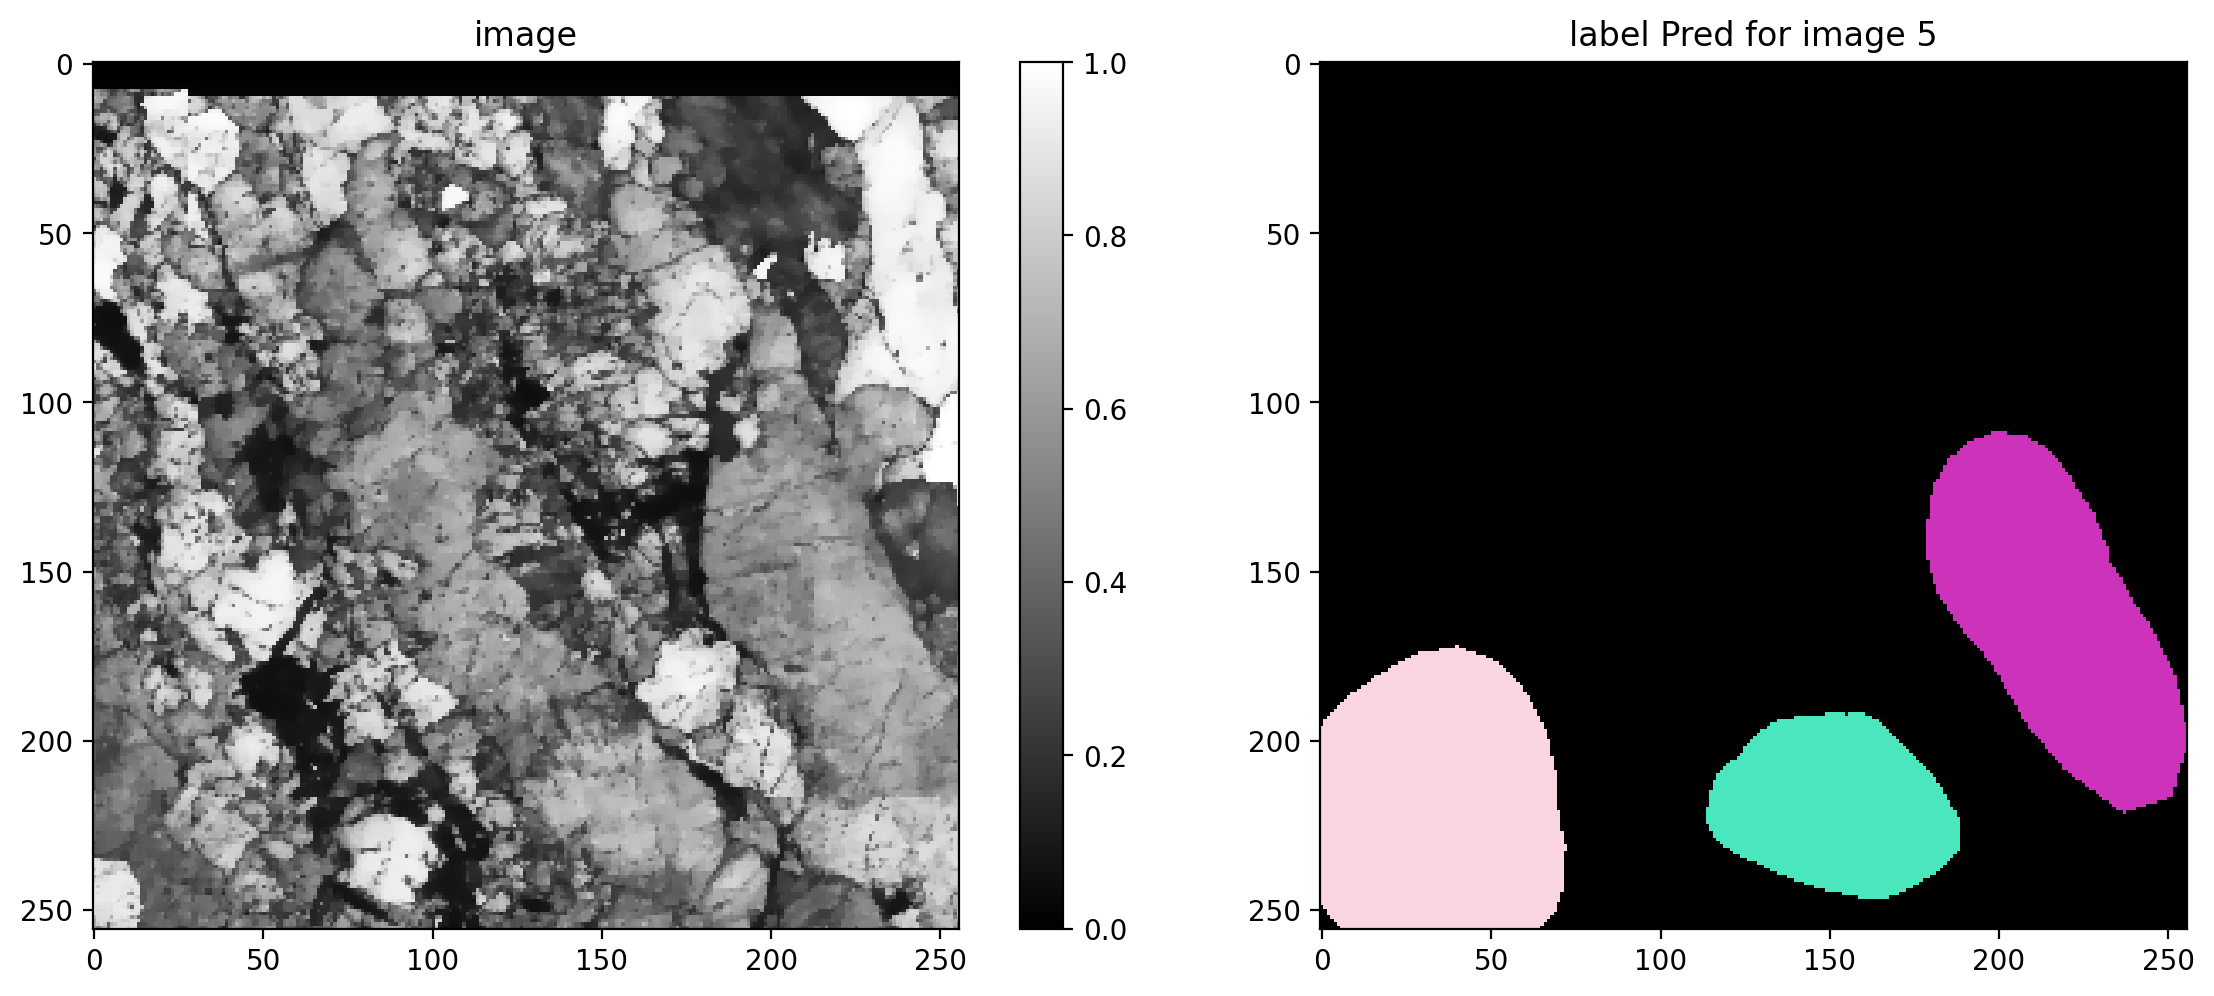

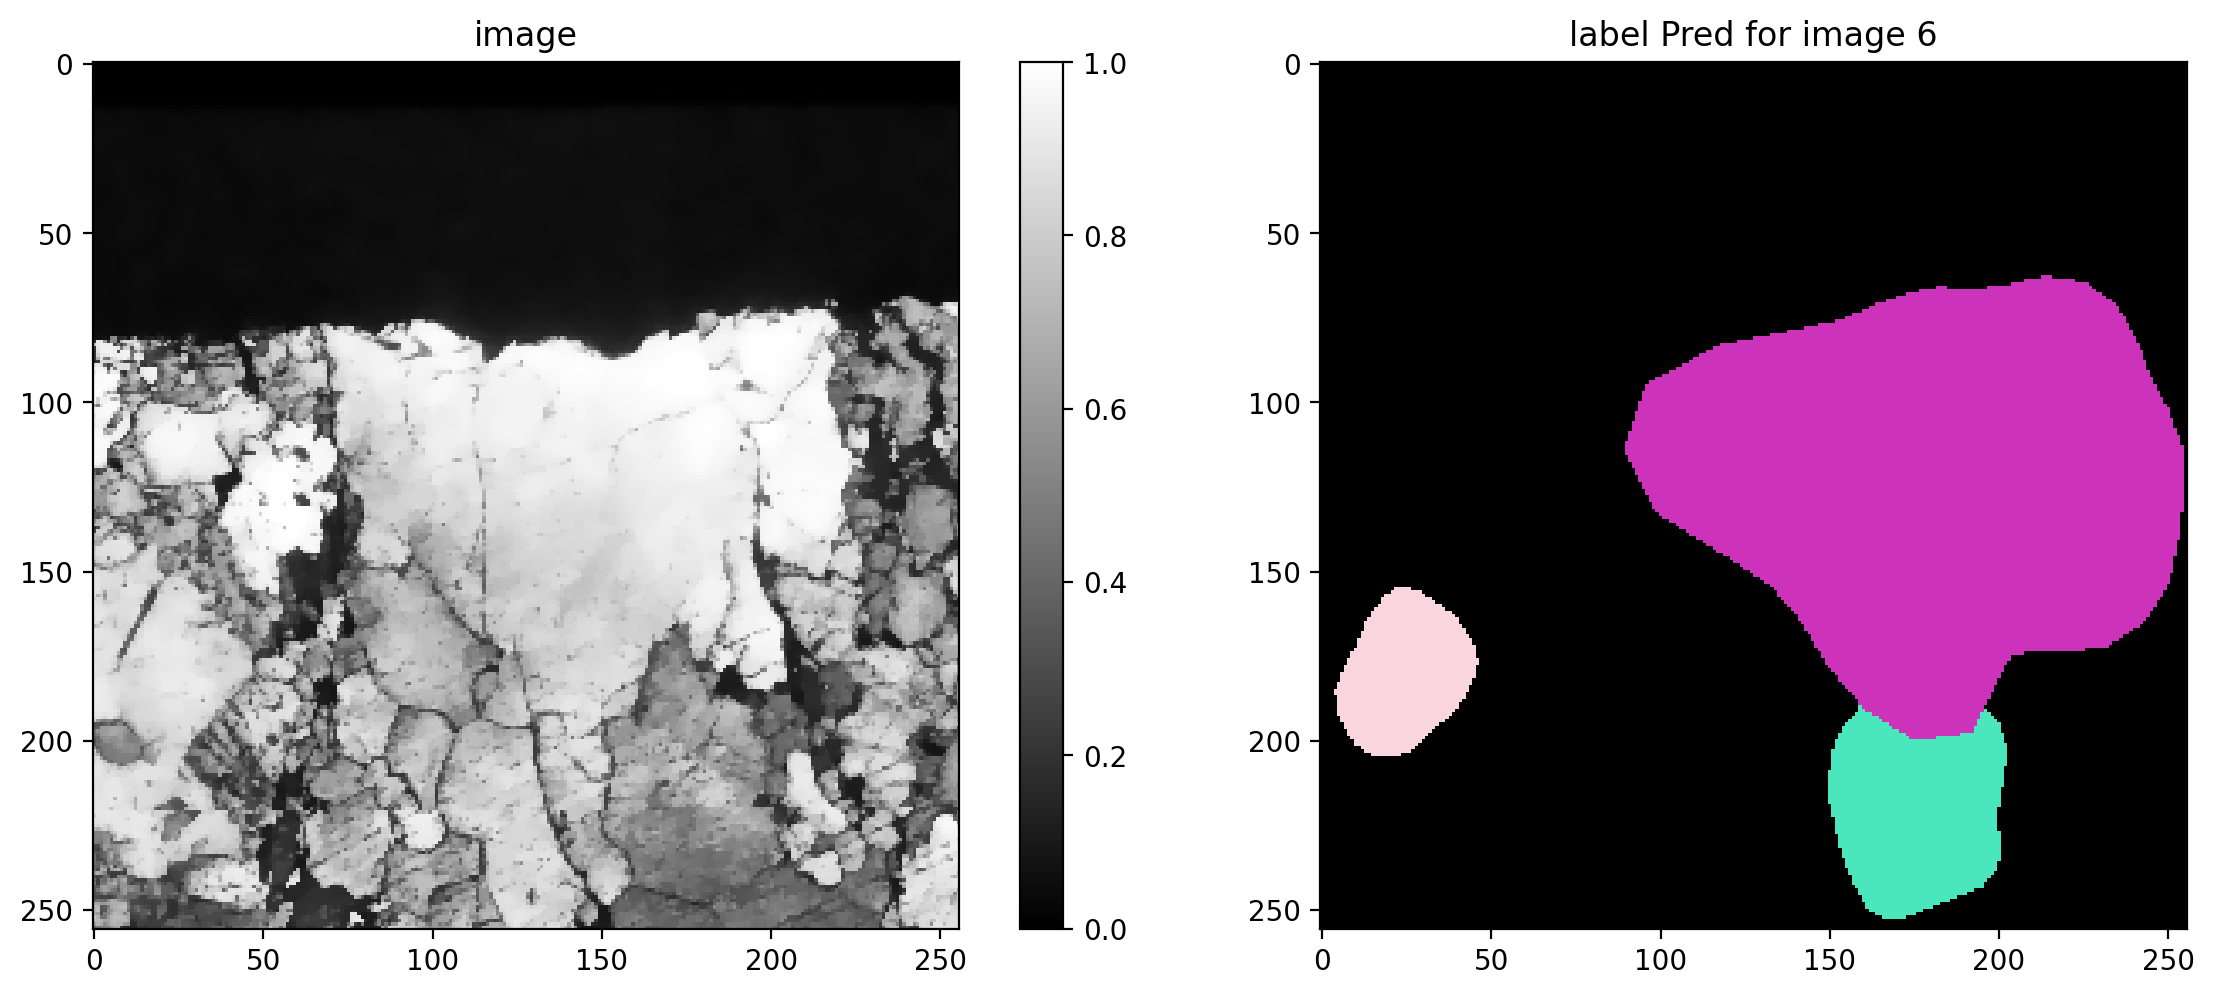

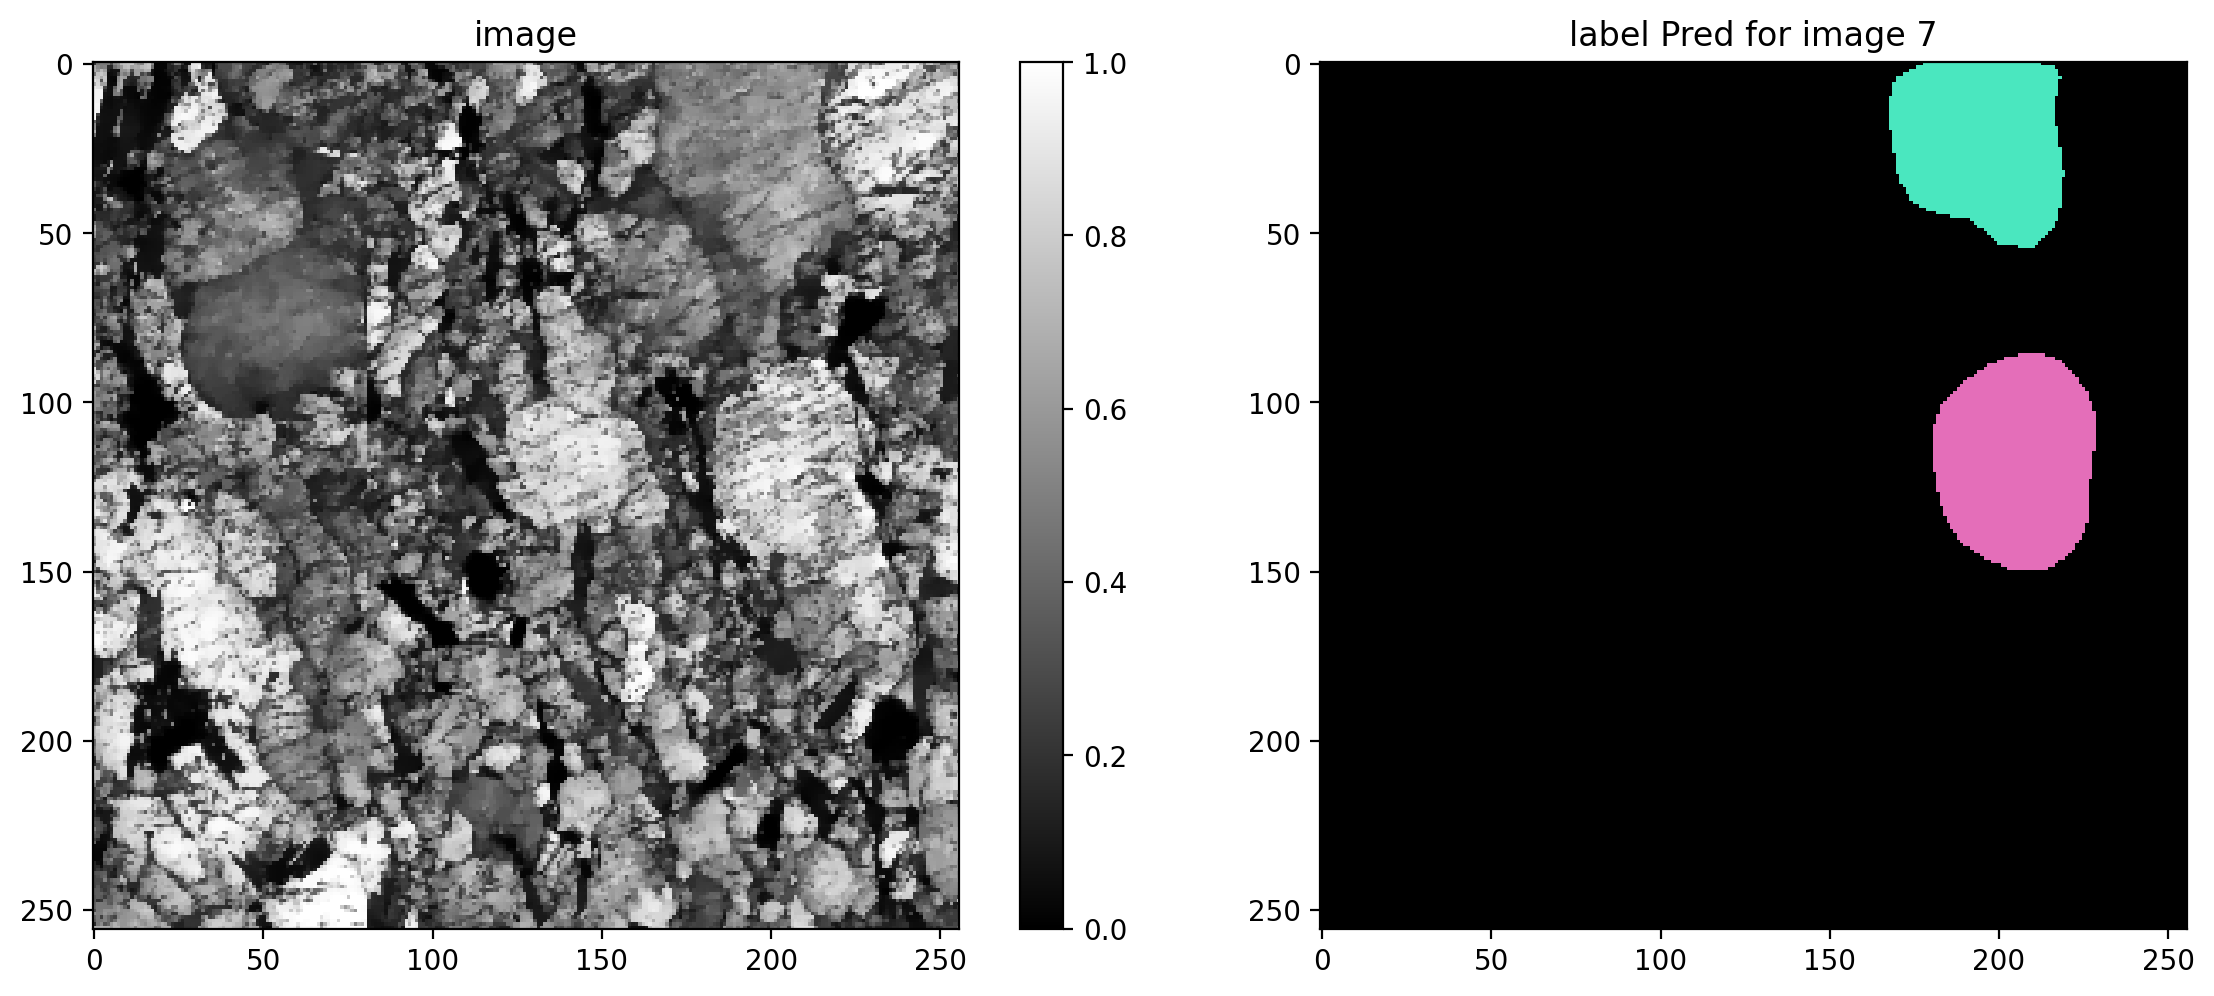

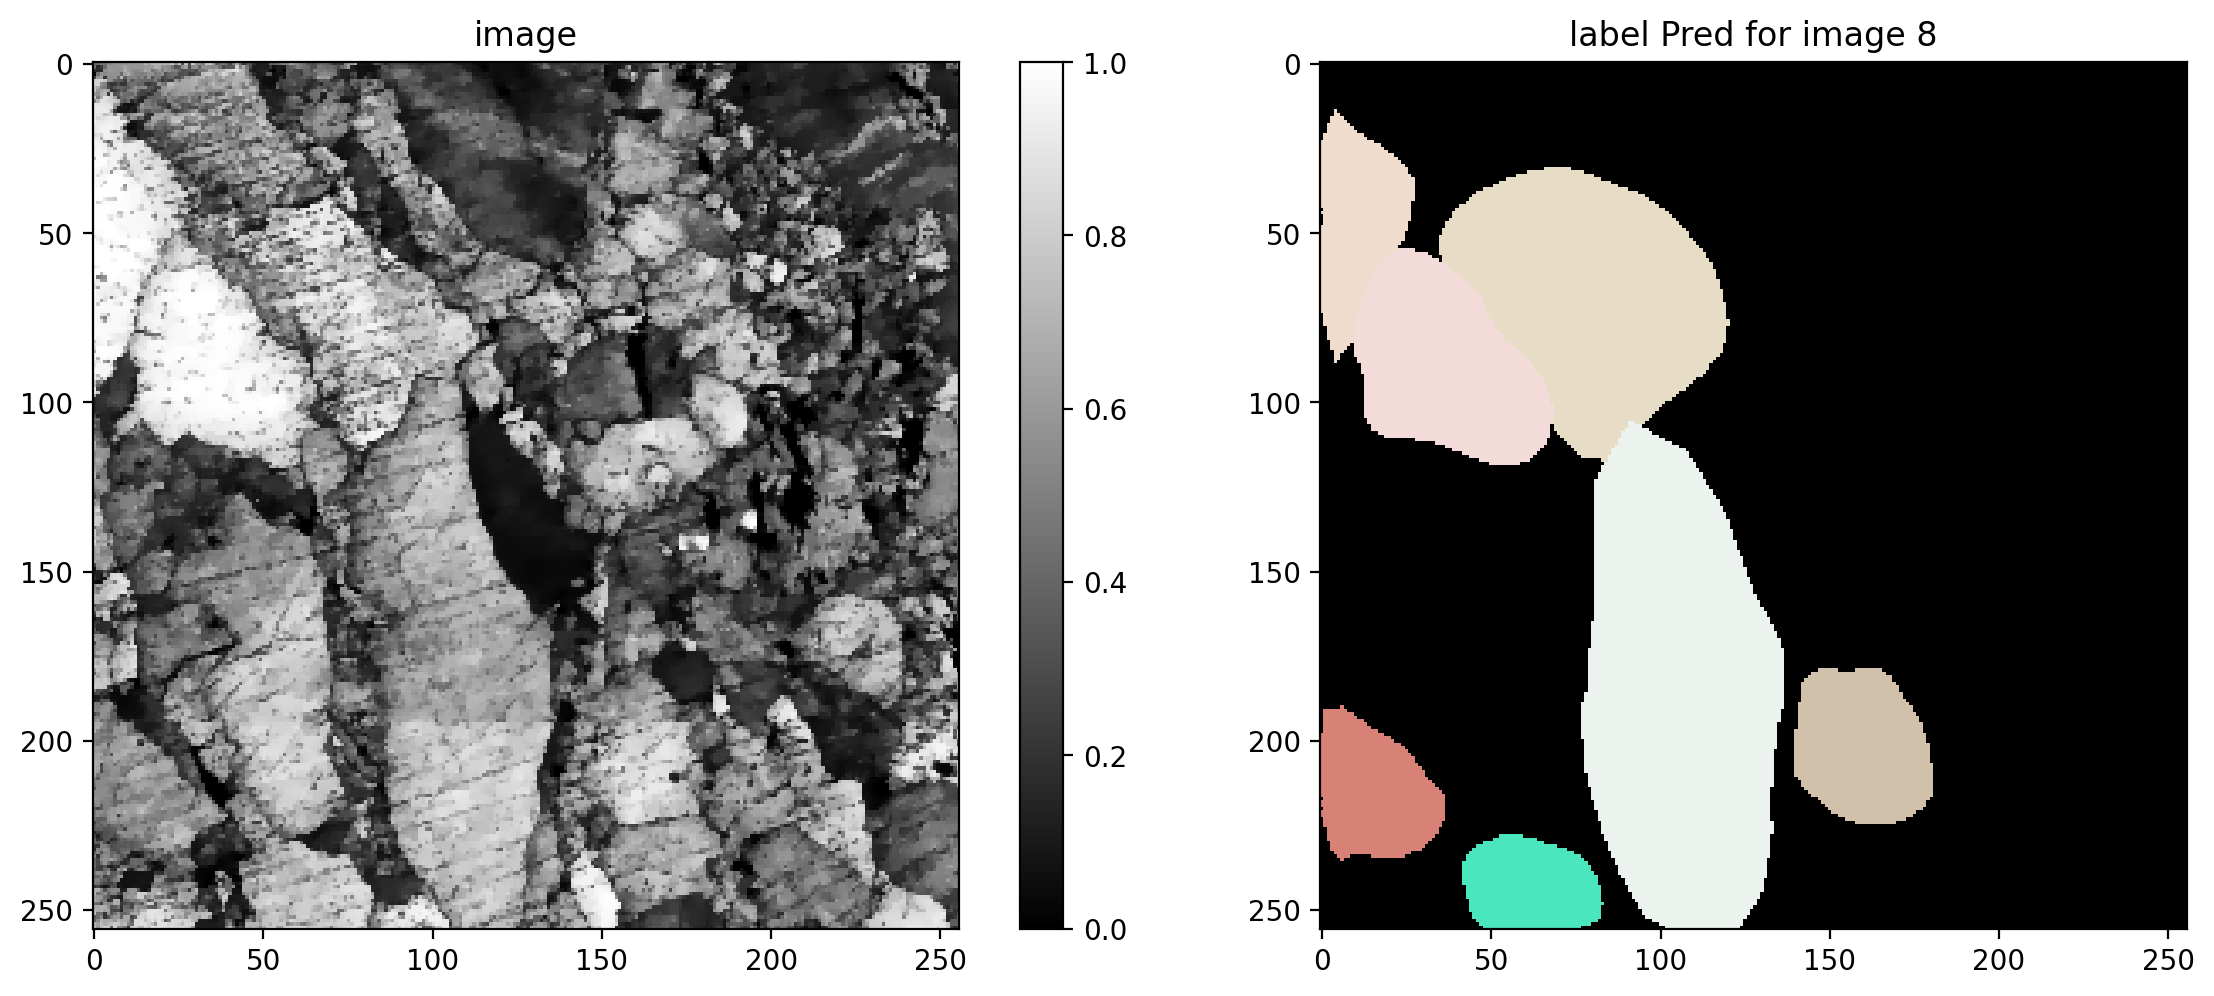

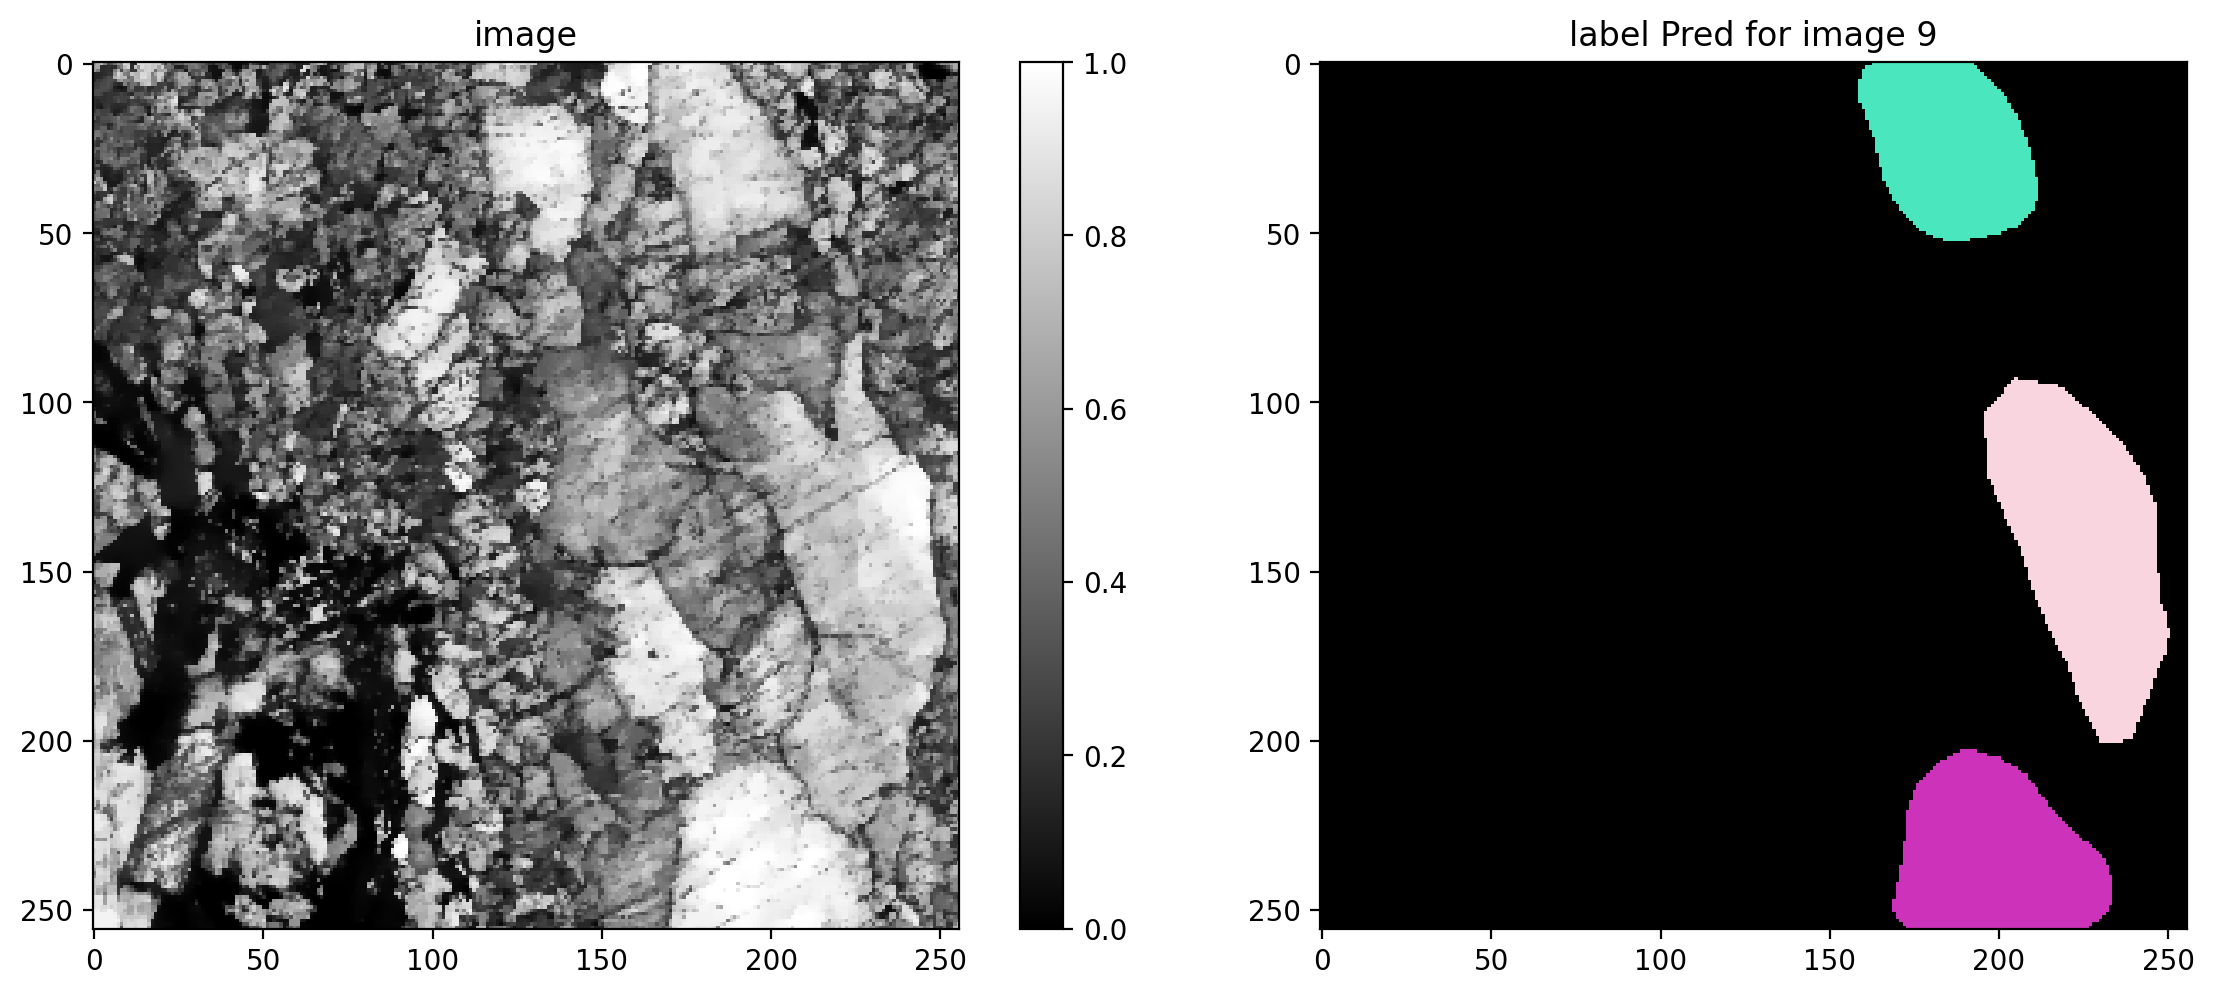

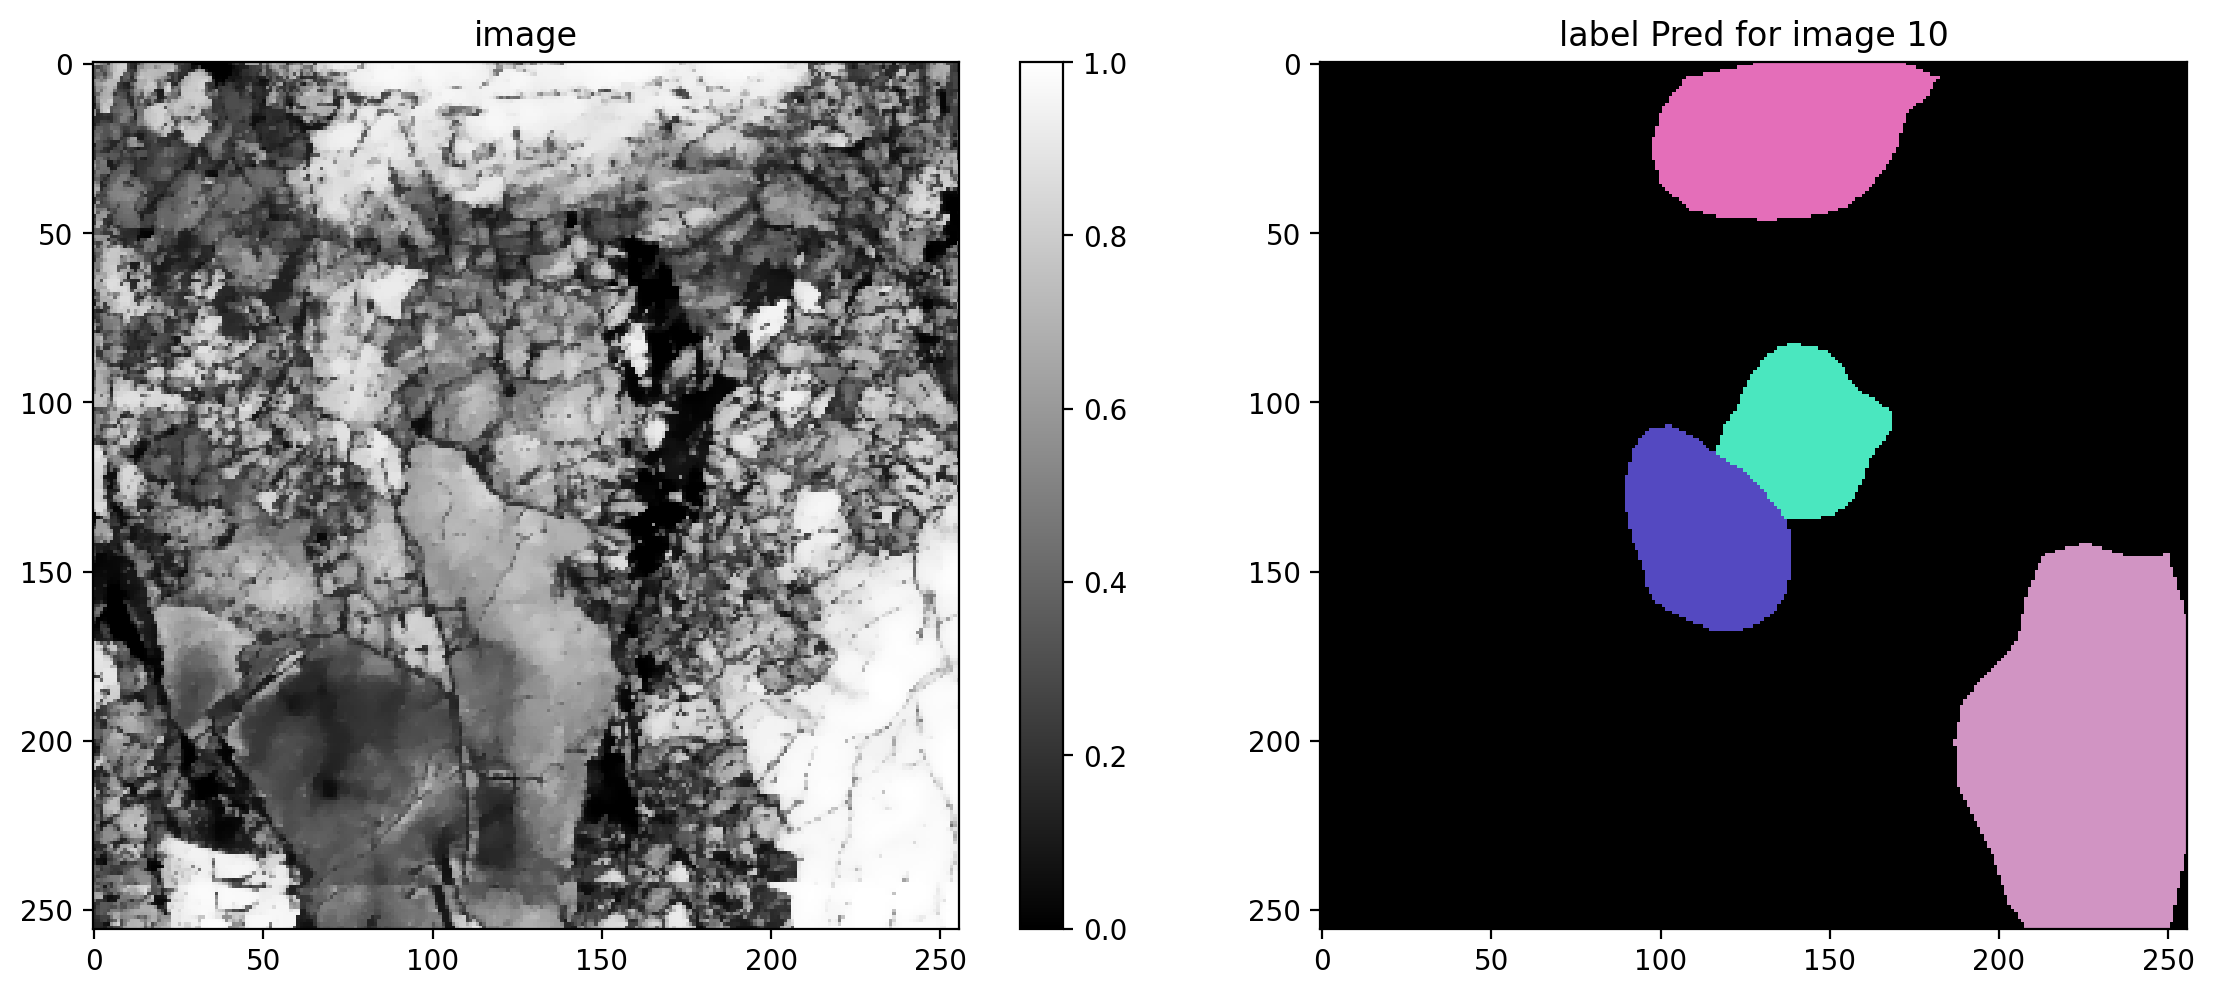

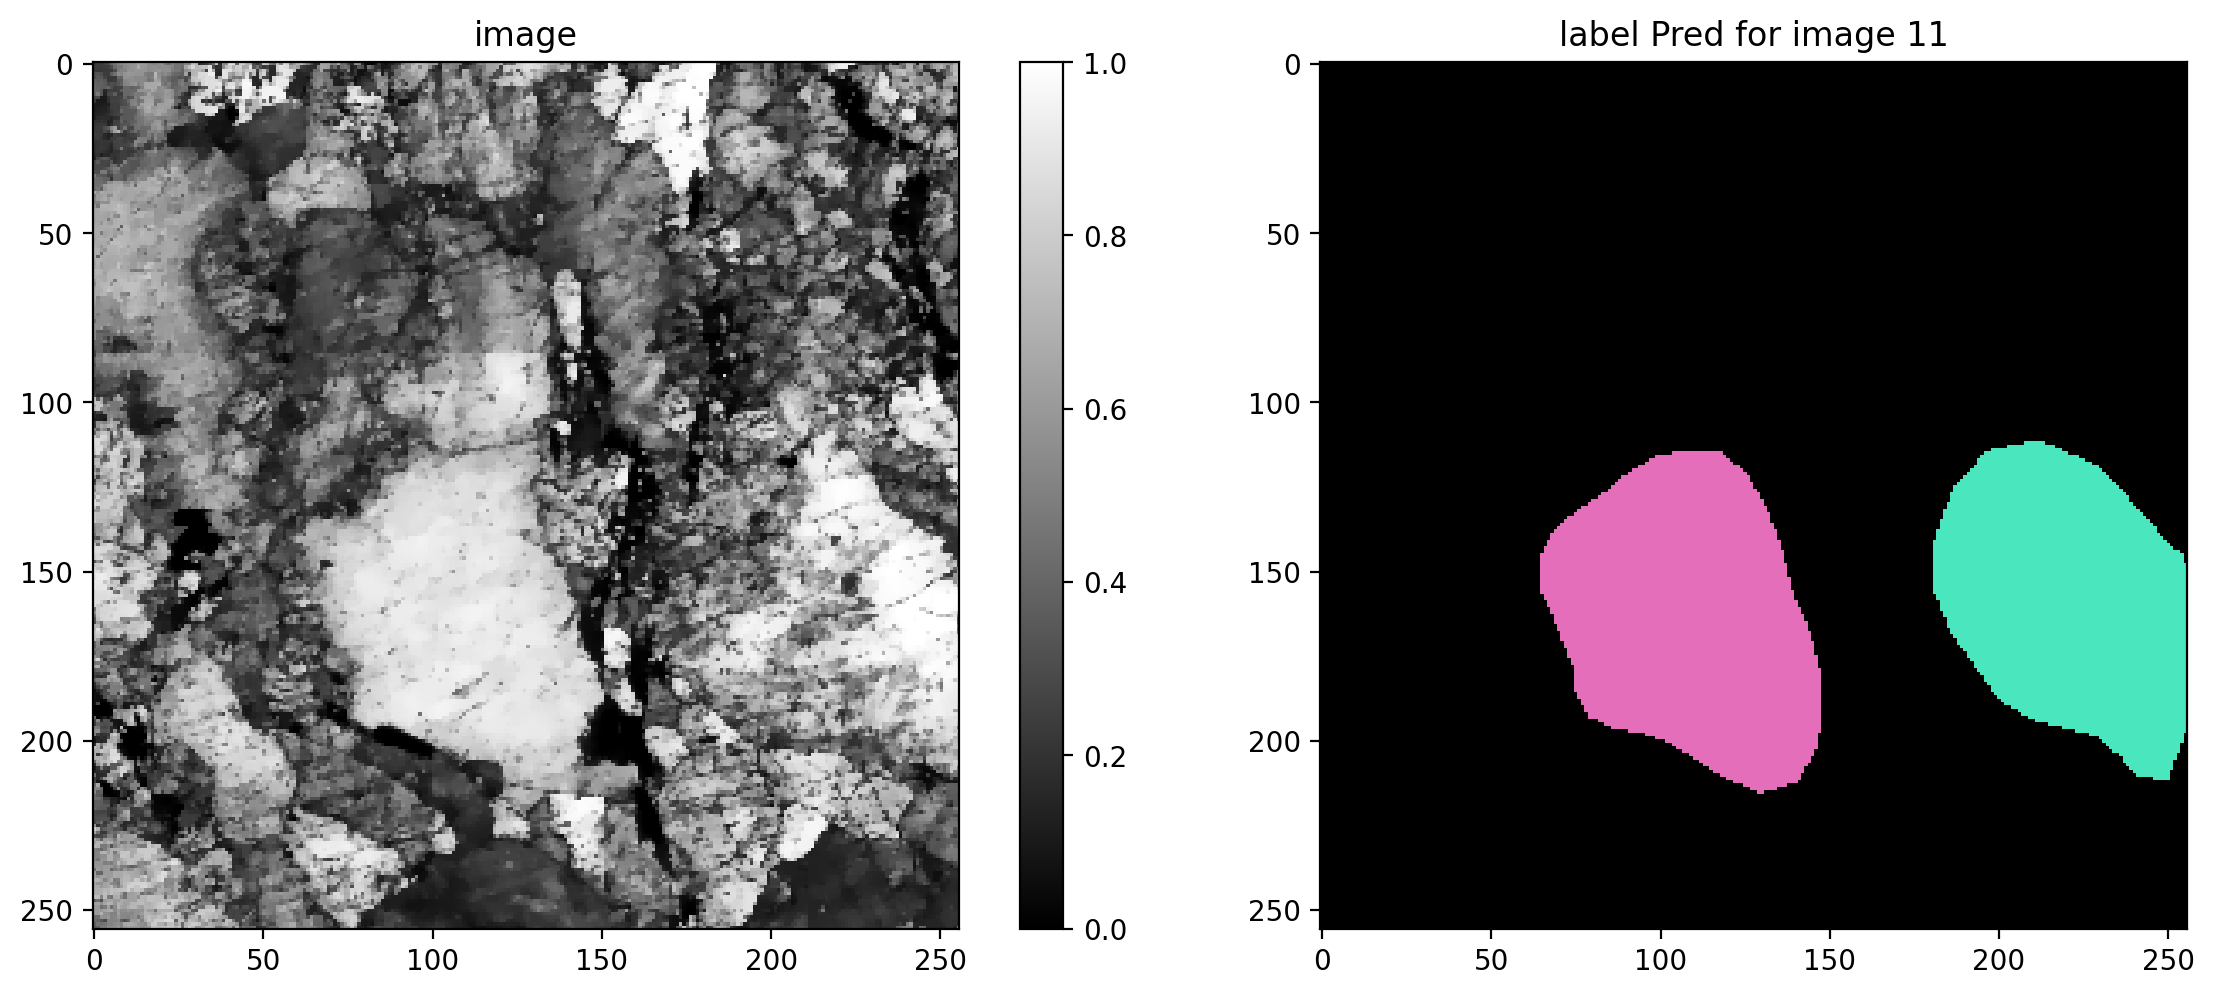

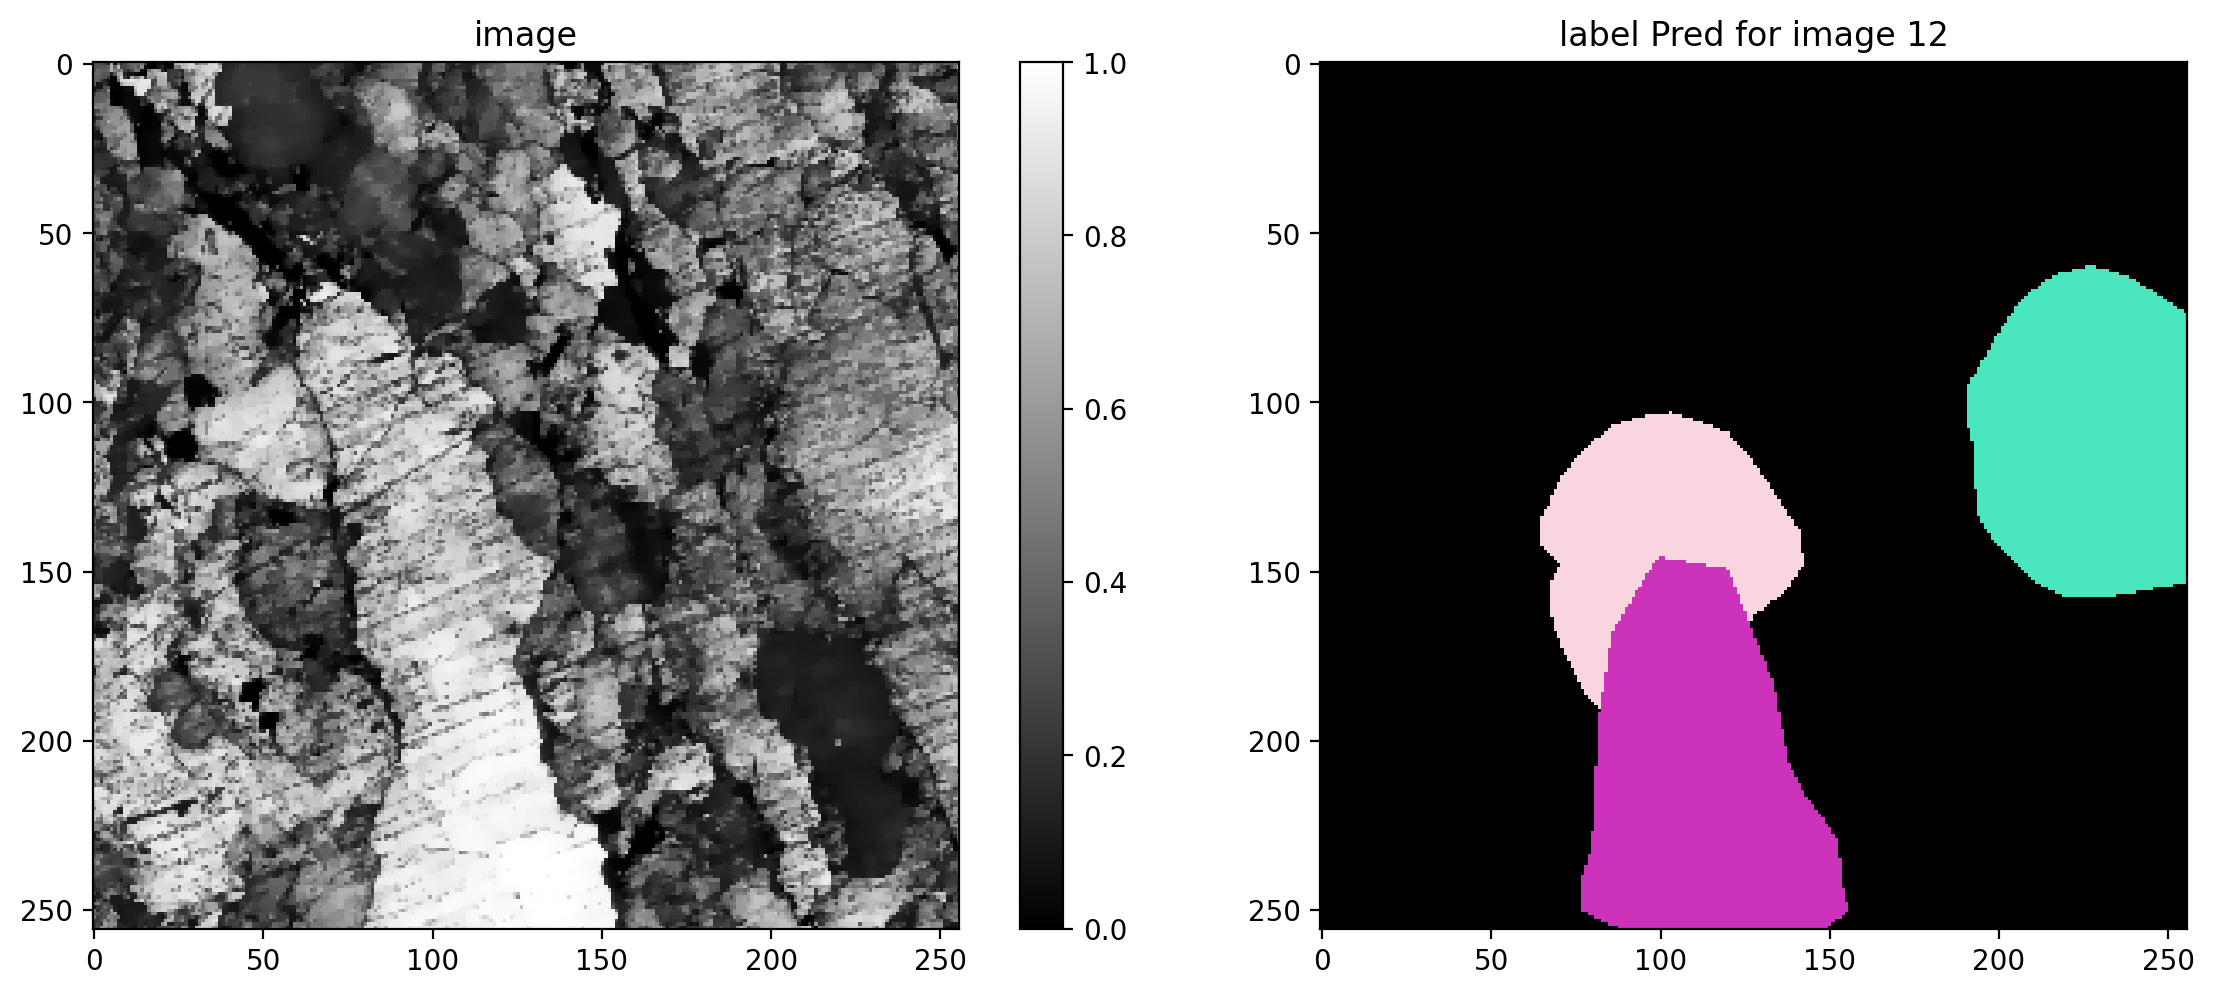

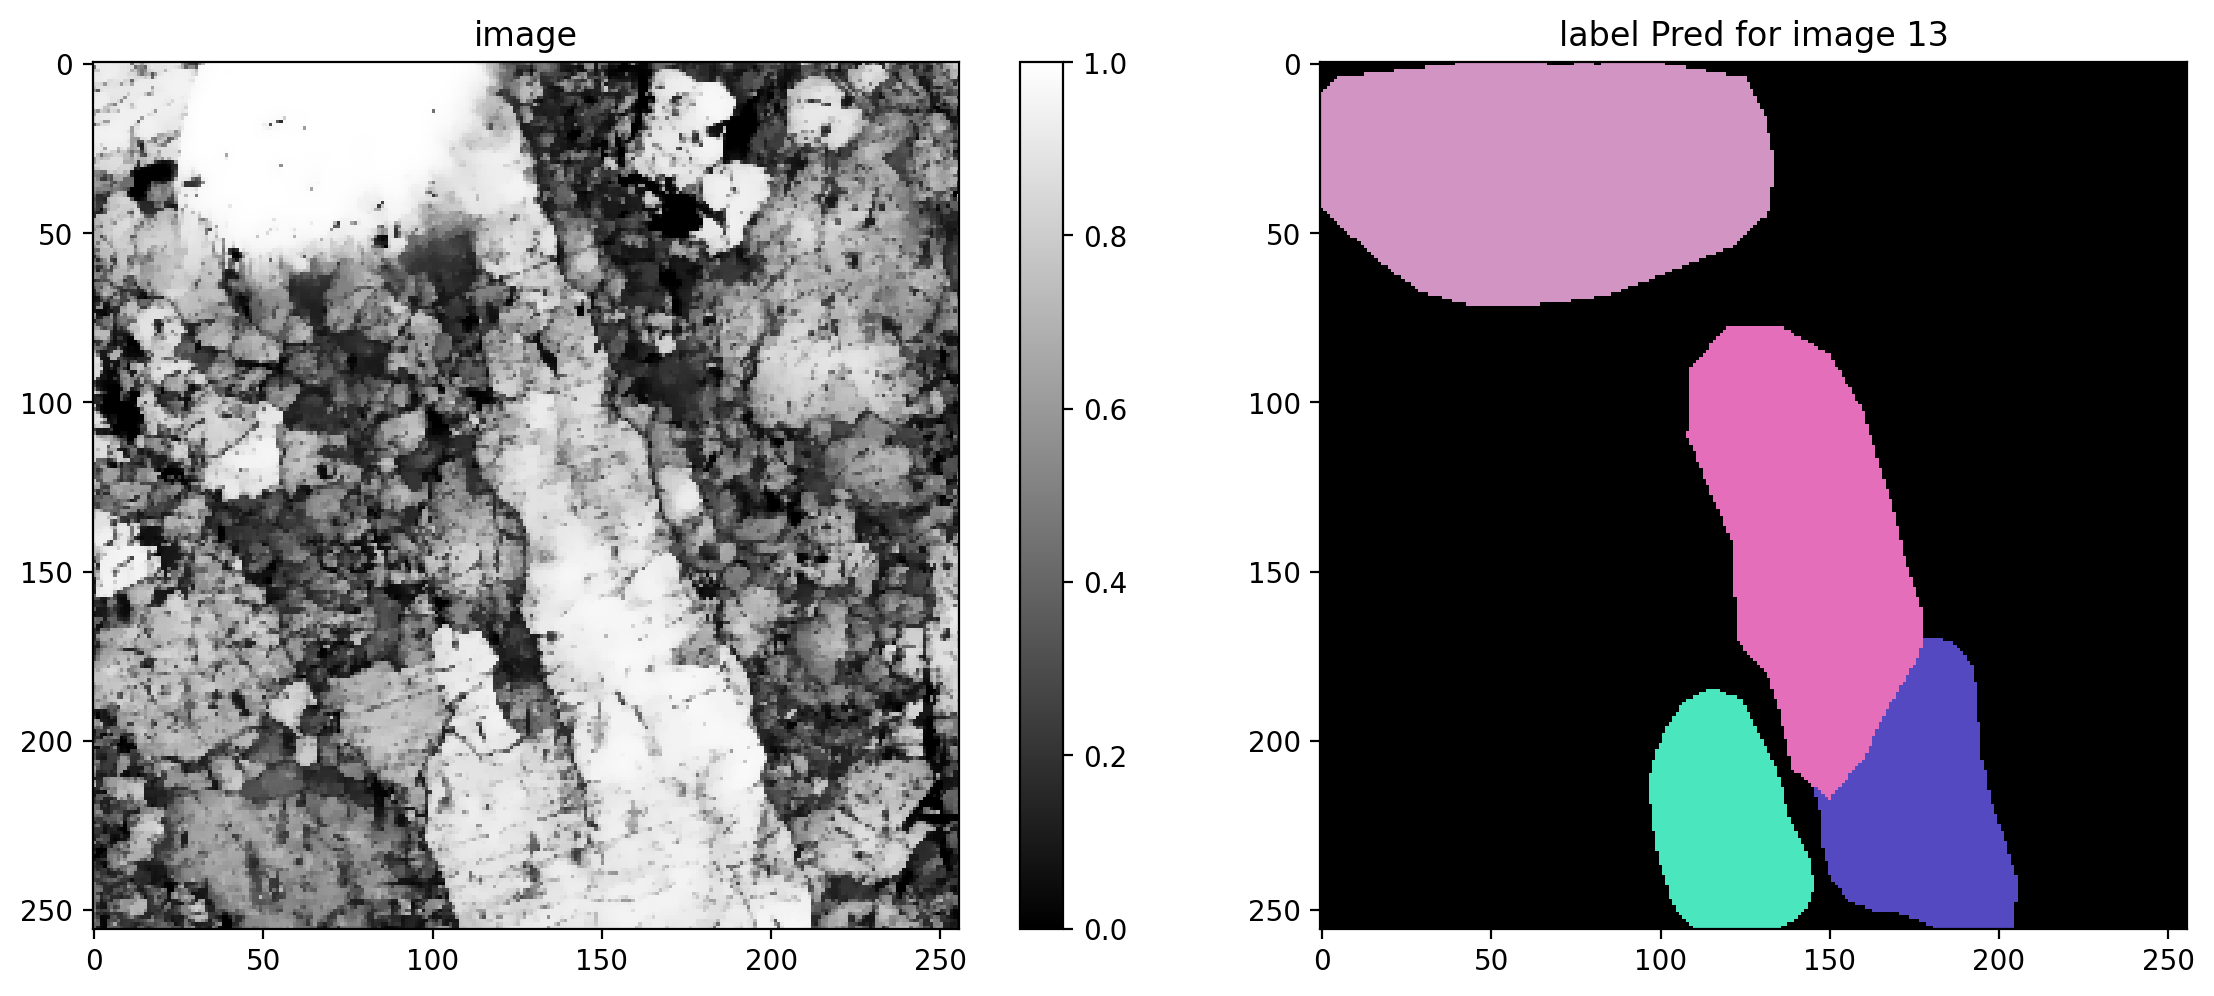

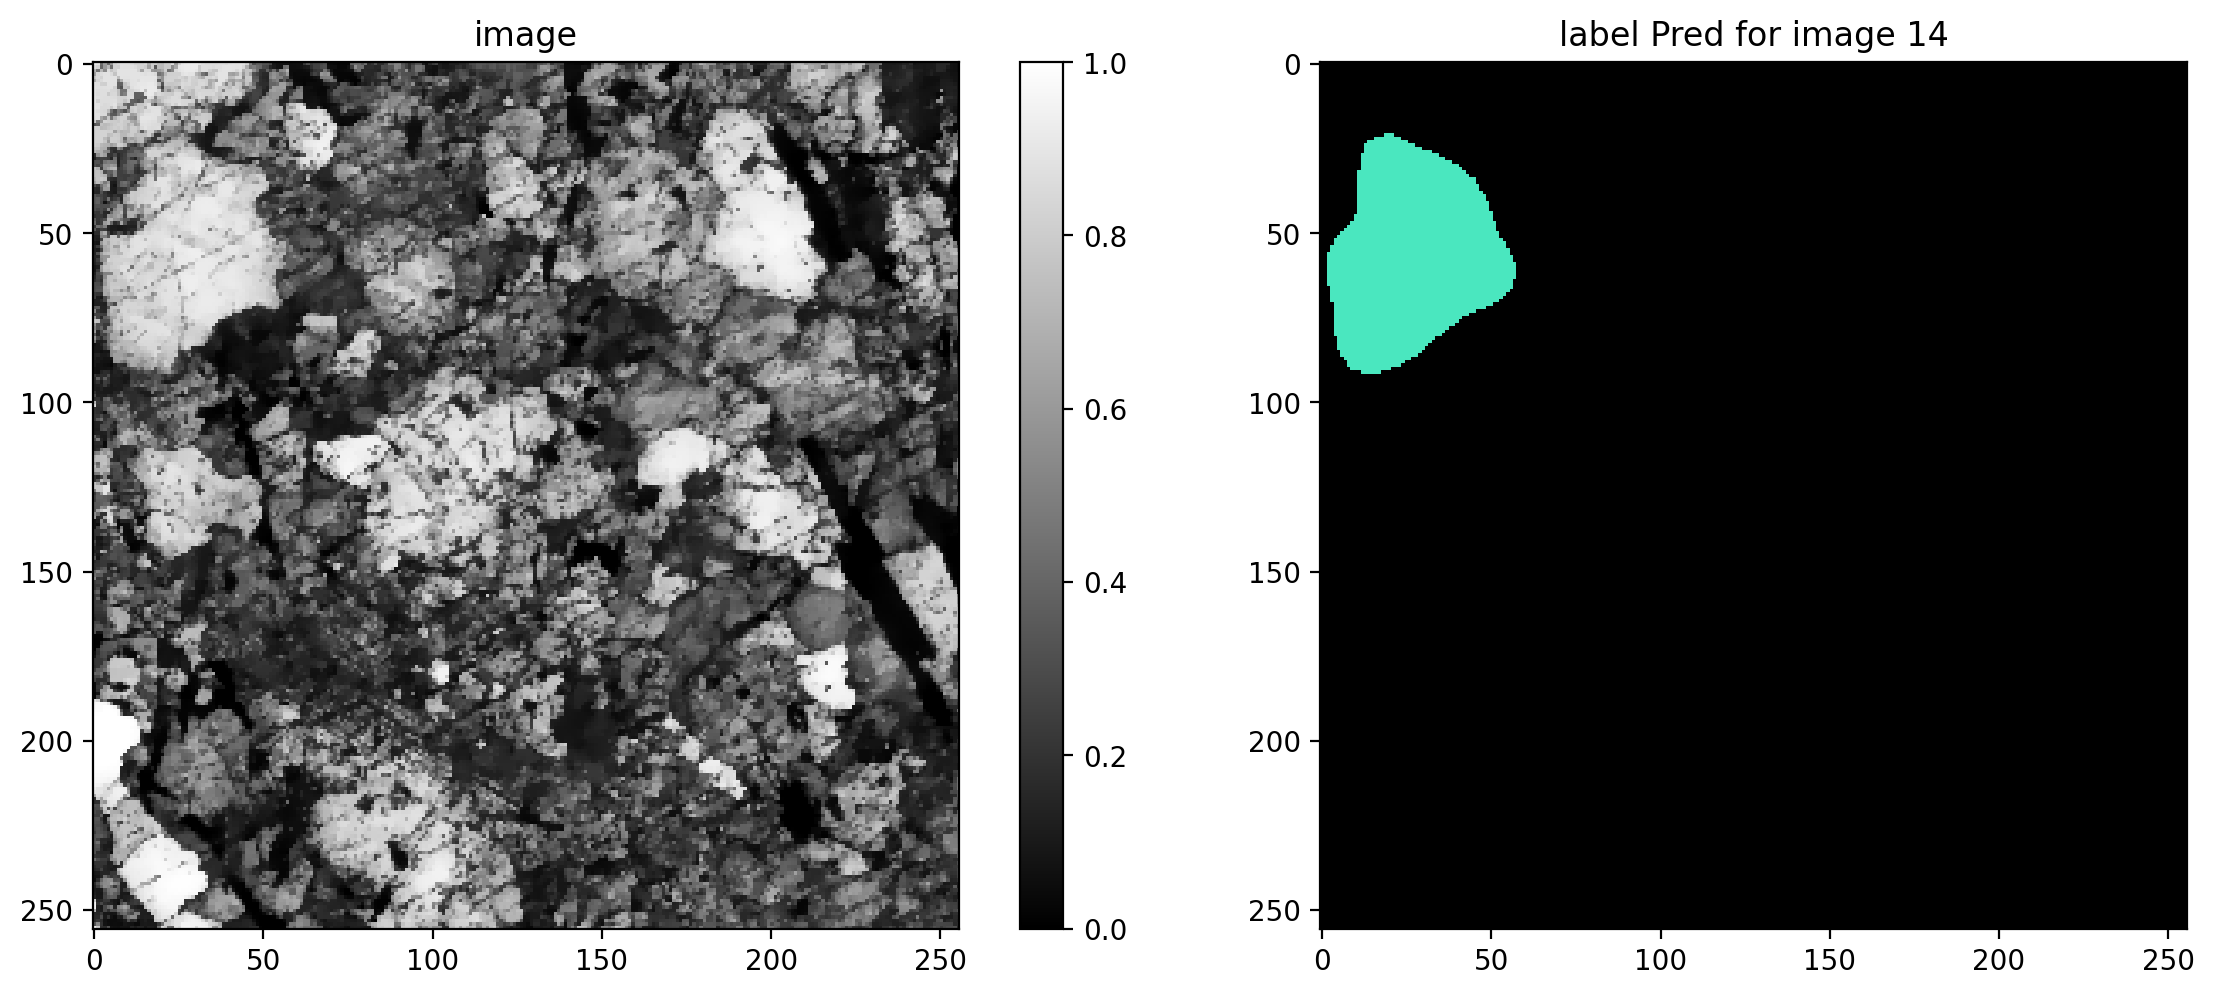

In [ ]:
for i in range(20):
    # plot_img_label(X_val[i], Y_val[i], lbl_title=f"label GT for image {i+1}")
    plot_img_label(X_val[i], Y_val_pred[i], lbl_title=f"label Pred for image {i+1}")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [ ]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:00<00:00, 21.48it/s]


Example: Print all available matching statistics for $\tau=0.5$

In [ ]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=24, tp=17, fn=57, precision=0.4146341463414634, recall=0.22972972972972974, accuracy=0.17346938775510204, f1=0.2956521739130435, n_true=74, n_pred=41, mean_true_score=0.17164102921614777, mean_matched_score=0.7471433036467608, panoptic_quality=0.22089454194773797, by_image=False)

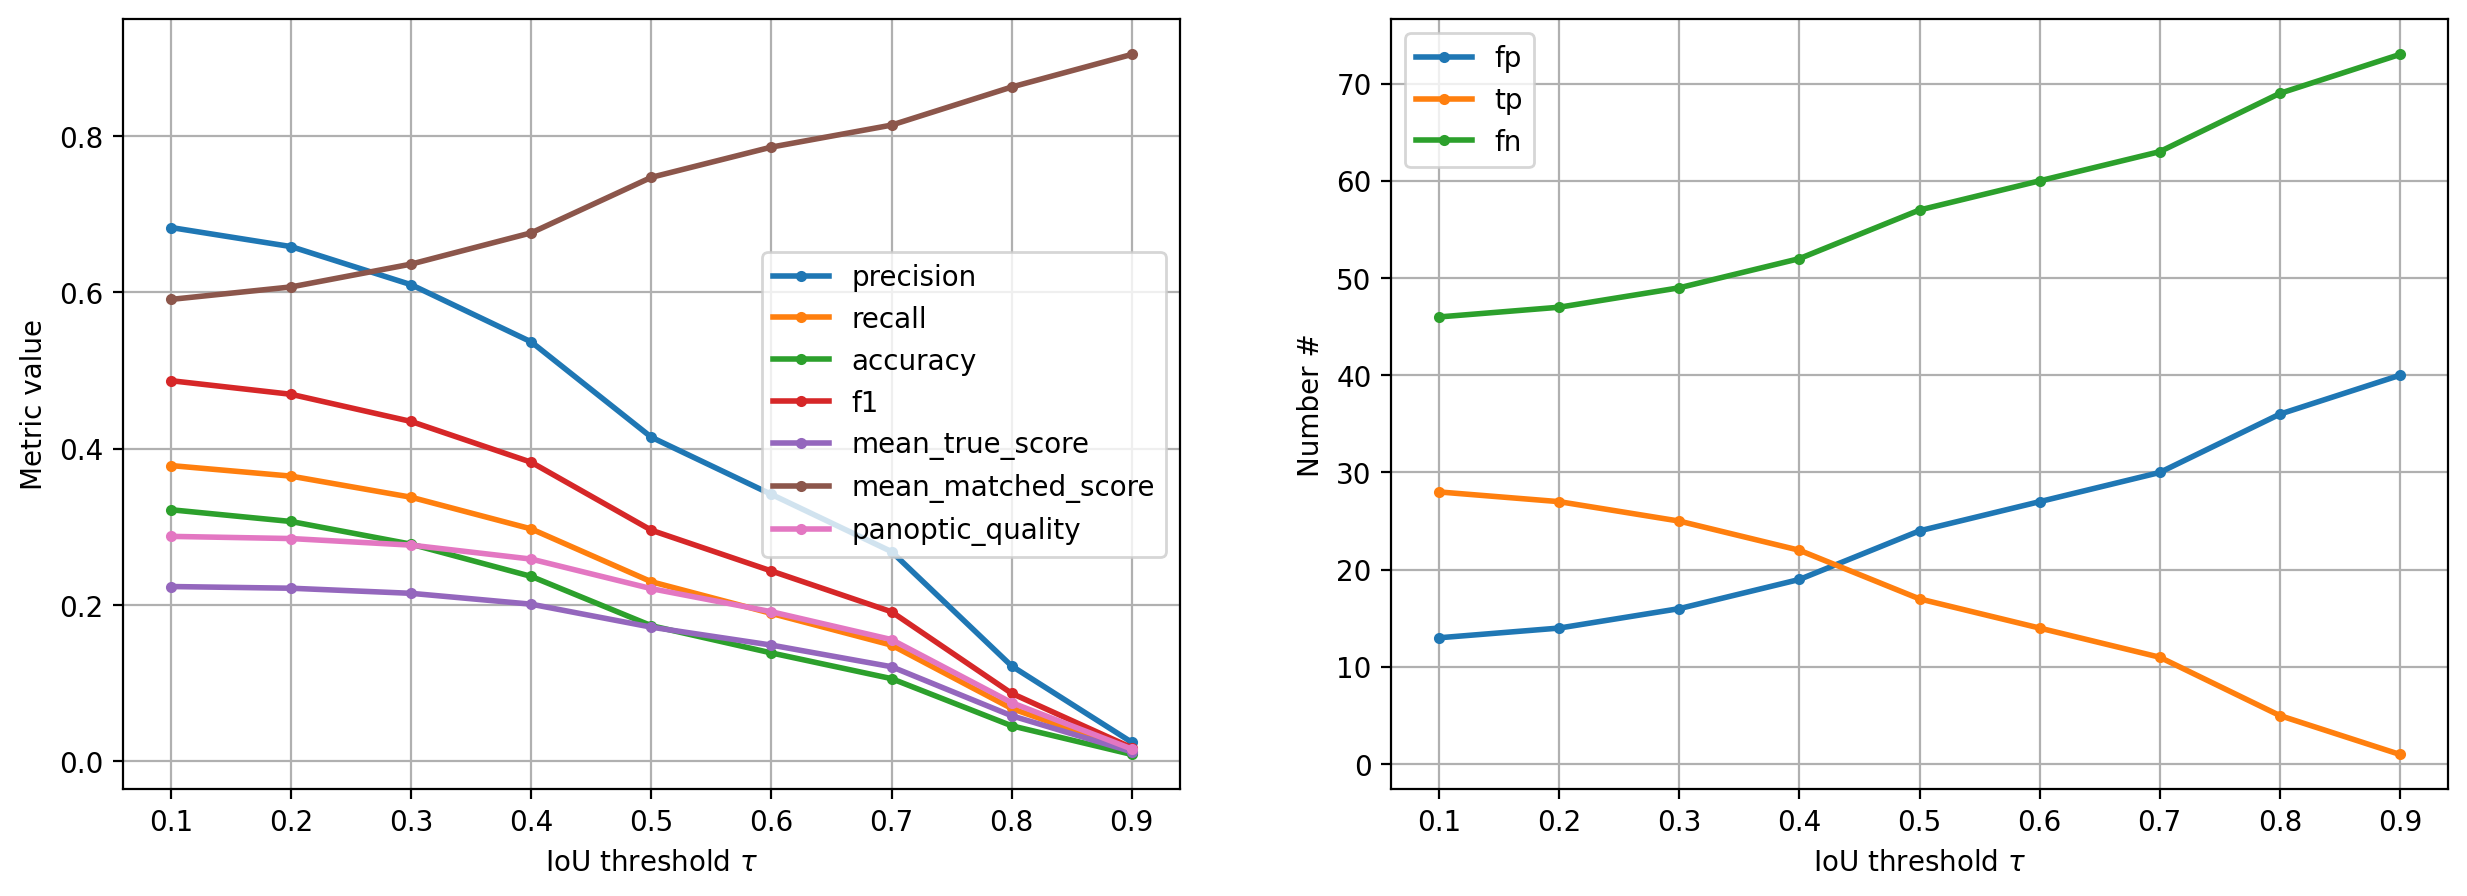

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();